In [146]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import scipy.signal
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
# import math
# from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import pandas as pd
import csv
myFmt = mdates.DateFormatter('%m-%d')

In [147]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [148]:
## SIMBA surface from SIMBA_surface_detection_v2_split_vertical.ipynb
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')

simba_sfc_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values


In [149]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
## new adjusted temps (no smoothing)
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'
simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = dt.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]

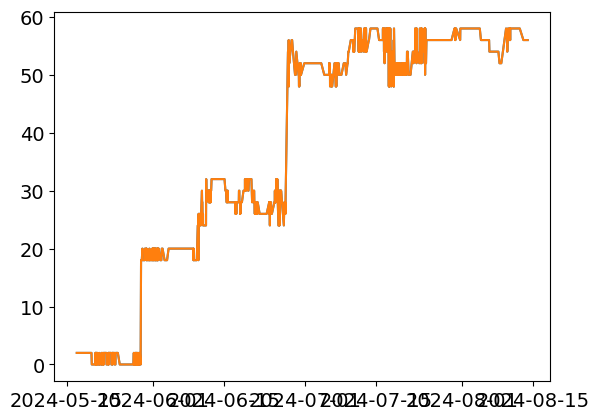

In [150]:
## interpolate simba_sfc to have same timesteps as rest of simba data
sfc_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_sfc_dates])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in season_data['dates']])

## surface looks too low here
plt.plot(simba_sfc_dates, simba_sfc_in, label='og')
# simba_sfc_in = np.ma.masked_where((simba_sfc_dates>=dt(2024,7,4,1))&(simba_sfc_dates<dt(2024,7,7,2)), simba_sfc_in)
# simba_sfc_in = np.ma.masked_where((simba_sfc_dates>=dt(2024,7,17,1))&(simba_sfc_in<45), simba_sfc_in)

plt.plot(simba_sfc_dates, simba_sfc_in, label='og masked')

f_sfc = interpolate.interp1d(sfc_seconds, simba_sfc_in, fill_value=-999, bounds_error=False)
simba_sfc = f_sfc(simba_seconds)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [151]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')

# asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/full_period/'
# asfs_lev2_files = glob.glob(asfs_filepath+'sleighsfsseb.sleighsfs.level2.0.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','snow_gpr_dist','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

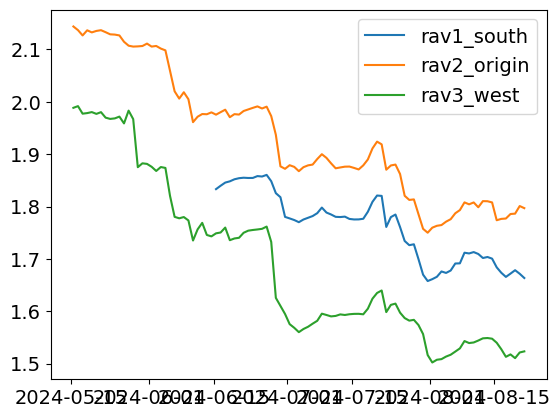

In [152]:
## load OGRE data
fig, ax = plt.subplots(1)
ogre_surface = {}

for ogre in ['rav1_south','rav2_origin','rav3_west']:
    df = pd.read_csv('/psd3data/arctic/sledd/Raven_OGRE/'+ogre+'.csv')
    
    ogre_date = np.array([dt.strptime(d, '%m/%d/%y %H:%M') for d in df['Datetime'].values])       
    ogre_sfc = df[' Average Ant. Height [m]'].values
    ogre_surface[ogre] = {'dates':ogre_date, 'sfc':ogre_sfc}
    ax.plot(ogre_date, ogre_sfc, label=ogre)
ax.legend(loc='best')

plt.show()

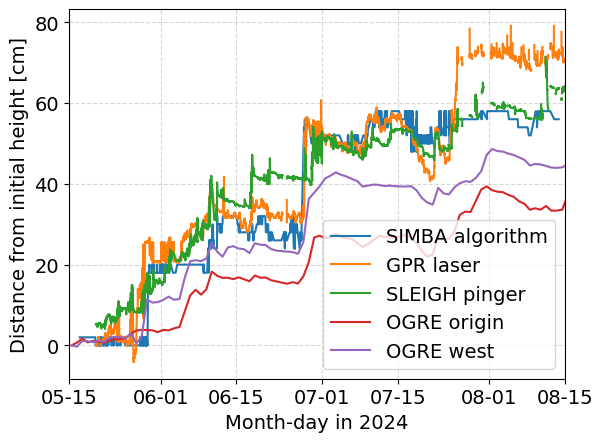

In [153]:
fig, ax = plt.subplots(1)
ax.plot(season_data['dates'], simba_sfc, label='SIMBA algorithm')

ax.plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser')
ax.plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger')

for ogre in ['rav2_origin','rav3_west']:
    ax.plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., label='OGRE '+ogre.split('_')[-1])

    
ax.legend(loc='best')
ax.grid(alpha=.5, ls='--')
ax.set_ylabel('Distance from initial height [cm]')

ax.set_xlim(dt(2024,5,15),dt(2024,8,15))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')

# plt.tight_layout()
plt.show()

Load more data: GPR melt index from Bob and Laura and solar corrected SIMBA

In [154]:
df = pd.read_csv('/psd3data/arctic/sledd/Melt_Index_despiked_GPR_Raven2024.csv')

gpr_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['date'].values])       
gpr_melt = df['Melt_Index_Normal'].values


In [155]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
# fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data_solar = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_solar['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn=='firnprofile_maxheight_solar-correction_created_20250417.nc':
        season_data_solar['temperature'] = fdic['temp']
    else:
        season_data_solar[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data_solar['height'] = season_data_solar['initial_height'][::-1]
    season_data_solar['temperature'] = season_data_solar['temperature'][:,::-1]
else:
    season_data_solar['height'] = season_data_solar['initial_height']

### Making figure that shows temperaratures above 0 below the surface as well as sifferent surfaces from other instruments

In [156]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
# fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data_unc = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_unc['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn=='firnprofile_maxheight_solar-correction_created_20250417.nc':
        season_data_unc['temperature'] = fdic['temp']
    else:
        season_data_unc[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data_unc['height'] = season_data_unc['initial_height'][::-1]
    season_data_unc['temperature'] = season_data_unc['temperature'][:,::-1]
else:
    season_data_unc['height'] = season_data_unc['initial_height']

In [157]:
plrams_fpath = '/home/asledd/ICECAPS/polarAMS2025/'

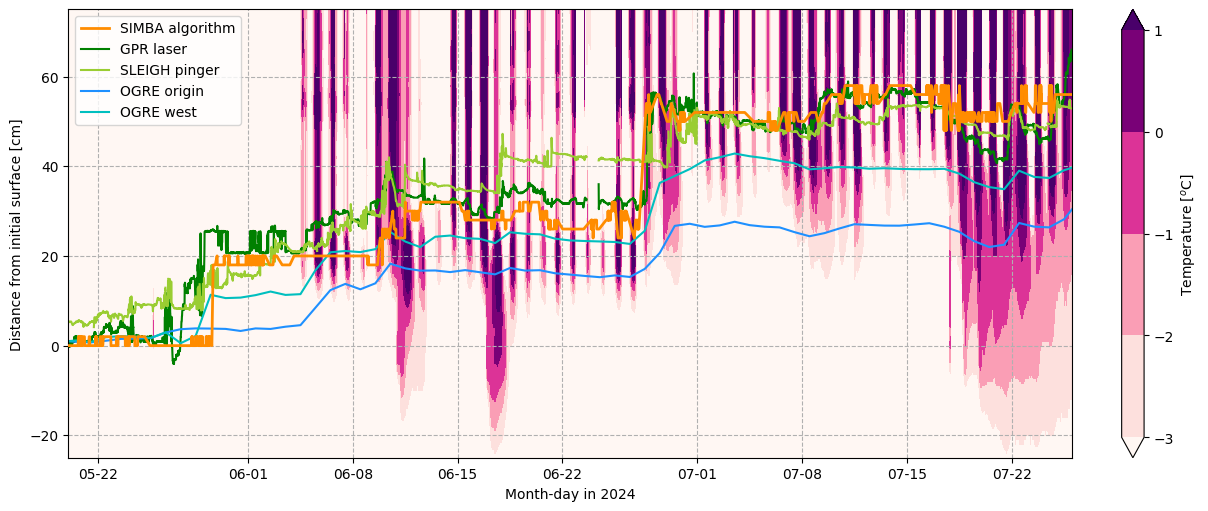

In [158]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1, figsize=(12,5), constrained_layout=True, sharex=False)

cmap = plt.cm.RdPu
# cmap = cmocean.cm.amp
cb = ax.contourf(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(season_data_unc['temperature'],0,1),
                cmap=cmap, levels=np.arange(-3,2,1), extend='both')
# ax.contour(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(season_data_unc['temperature'],0,1),
#                 levels=[1], extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [$^o$C]')

ax.grid(ls='--')

ax.plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='darkorange', lw=2, zorder=10)

ax.plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser', c='green')
ax.plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='yellowgreen')

for ogre, c in zip(['rav2_origin','rav3_west'],['dodgerblue', 'c']):
    ax.plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., 
            label='OGRE '+ogre.split('_')[-1], c=c)

ax.legend(loc='upper left')

ax.set_ylabel('Distance from initial surface [cm]')
ax.set_ylim(-25, 75)

ax.set_xlim(datetime.datetime(2024,5,20),datetime.datetime(2024,7,26))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)
# plt.savefig(plrams_fpath+'SIMBA_uncorrected_T_sfc-comparisons.png', dpi=300)

plt.show()

In [463]:
second_vert_grad = np.gradient(np.gradient(season_data_unc['temperature'], axis=1),axis=1)

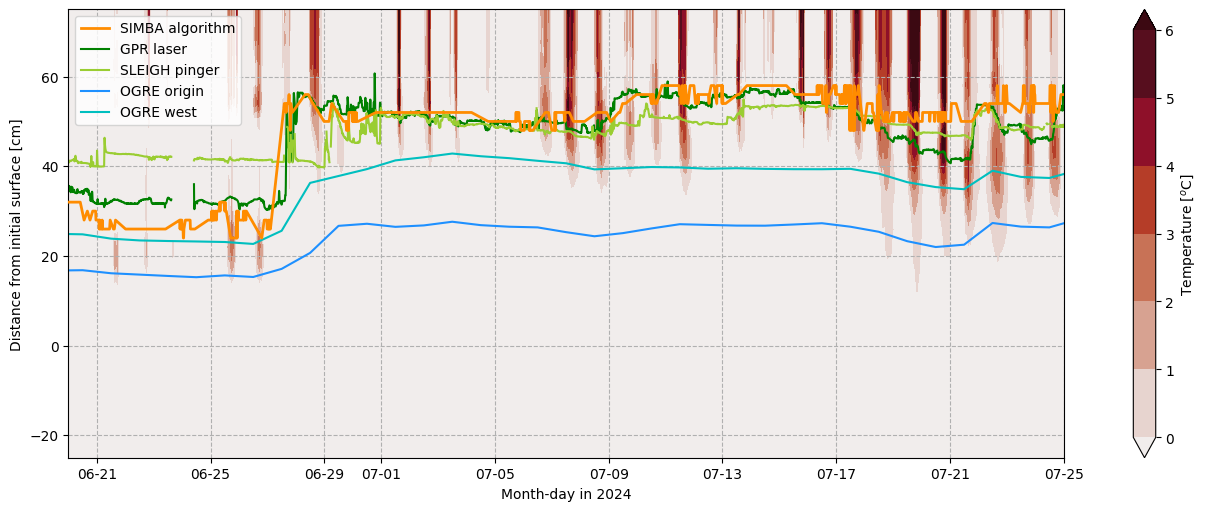

In [475]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1, figsize=(12,5), constrained_layout=True, sharex=False)


cmap = cmocean.cm.amp
cb = ax.contourf(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(season_data_unc['temperature'],0,1),
                cmap=cmap, levels=np.arange(0,7,1), extend='both')
# ax.contour(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(season_data_unc['temperature'],0,1),
#                 levels=[1], extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [$^o$C]')

ax.grid(ls='--')

ax.plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='darkorange', lw=2, zorder=10)

ax.plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser', c='green')
ax.plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='yellowgreen')

for ogre, c in zip(['rav2_origin','rav3_west'],['dodgerblue', 'c']):
    ax.plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., 
            label='OGRE '+ogre.split('_')[-1], c=c)

ax.legend(loc='upper left')

ax.set_ylabel('Distance from initial surface [cm]')
ax.set_ylim(-25, 75)

ax.set_xlim(datetime.datetime(2024,6,20),datetime.datetime(2024,7,25))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)
# plt.savefig(plrams_fpath+'SIMBA_uncorrected_T_sfc-comparisons.png', dpi=300)

plt.show()

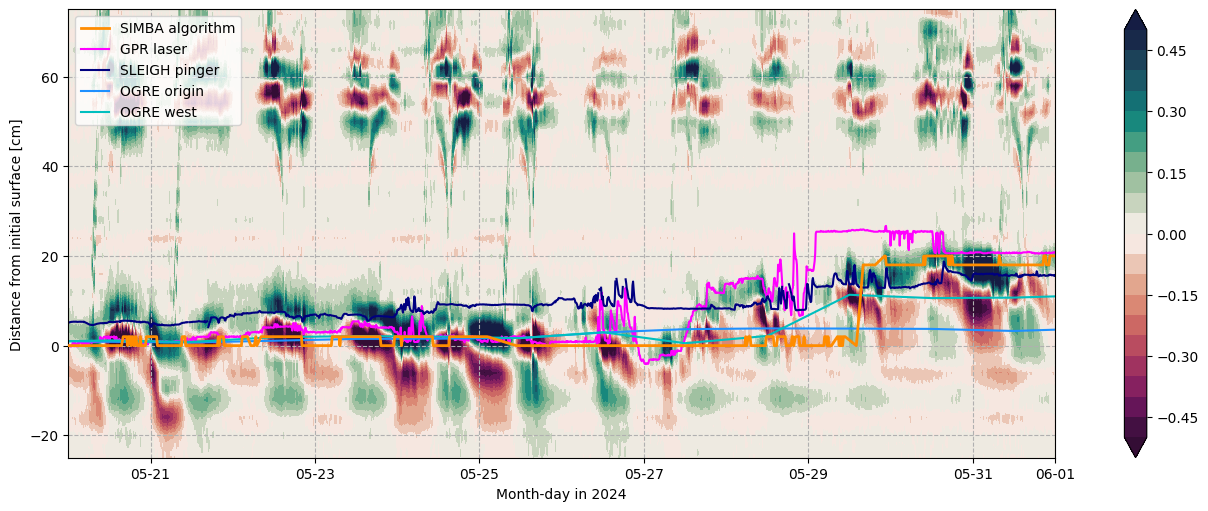

In [645]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1, figsize=(12,5), constrained_layout=True, sharex=False)


cmap = cmocean.cm.curl_r
cb = ax.contourf(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(second_vert_grad,0,1),
                cmap=cmap, levels=np.arange(-.5,.51,.05), extend='both')
# ax.contour(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(season_data_unc['temperature'],0,1),
#                 levels=[1], extend='both')
plt.colorbar(cb, ax=ax, label='')

ax.grid(ls='--')

ax.plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='darkorange', lw=2, zorder=10)

ax.plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., 
        label='GPR laser', c='magenta')
ax.plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='navy')

for ogre, c in zip(['rav2_origin','rav3_west'],['dodgerblue', 'c']):
    ax.plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., 
            label='OGRE '+ogre.split('_')[-1], c=c)

ax.legend(loc='upper left')

ax.set_ylabel('Distance from initial surface [cm]')
ax.set_ylim(-25, 75)

ax.set_xlim(datetime.datetime(2024,5,20),datetime.datetime(2024,6,1))

# ax.set_xlim(datetime.datetime(2024,6,15),datetime.datetime(2024,7,1))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)
# plt.savefig(plrams_fpath+'SIMBA_uncorrected_T_sfc-comparisons.png', dpi=300)

plt.show()

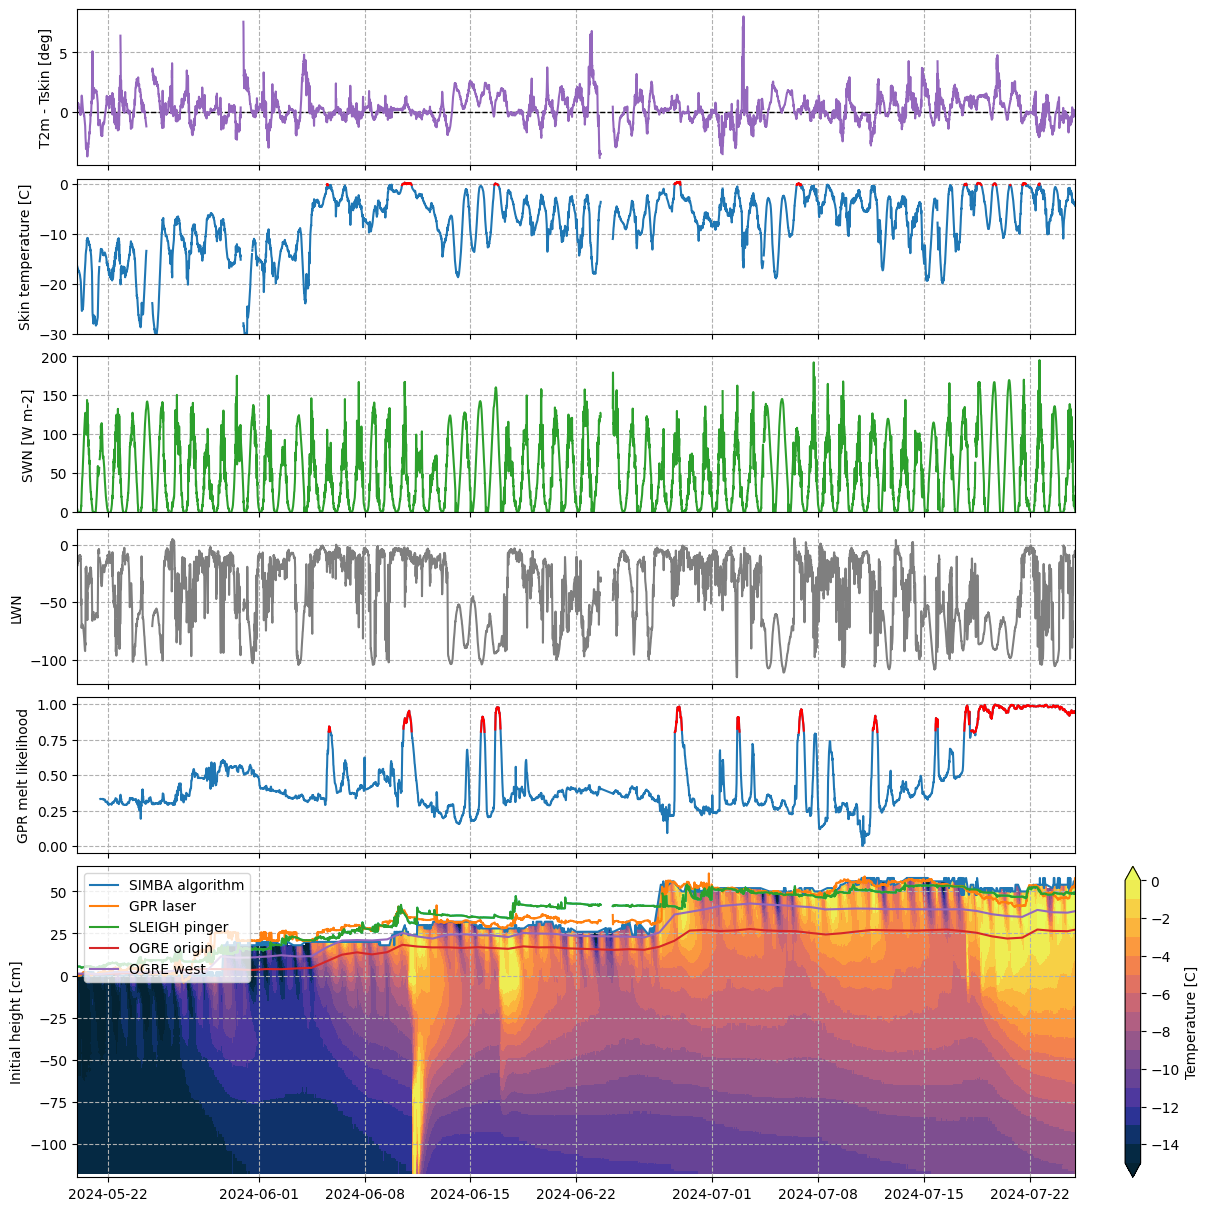

In [159]:
fig, axs = plt.subplots(6, figsize=(12,12), constrained_layout=True, 
                        sharex=True, gridspec_kw=dict(height_ratios=[1,1,1,1,1,2]))


# cb = axs[-1].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
#                 cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
# plt.colorbar(cb, ax=axs[-1], label='Temperature [C]')
# cb = axs[-1].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
#                 levels=[0], extend='both', lw=1)
# axs[-1].set_ylabel('Distance from top of SIMBA [cm]')

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp']-273.15)
axs[1].plot(asfs_data_lev2['dates'], np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.32), c='r')
axs[1].set_ylabel('Skin temperature [C]')

axs[0].axhline(y=0, c='k', ls='--', lw=1)
axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15), c='tab:purple')
axs[0].set_ylabel('T2m - Tskin [deg]')

axs[2].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='tab:green')
axs[2].set_ylabel('SWN [W m-2]')


# axs[3].plot(asfs_data_lev2['dates'], albedo, lw=1)
# axs[3].plot(asfs_data_lev2['dates'], albedo_smoothed,)

# axs[3].set_ylabel('SWU/SWD')
# axs[3].set_ylim(0.6,1)

# axs[0].set_xlim(datetime.datetime(2024,7,18),datetime.datetime(2024,7,25))
axs[1].set_ylim(-30,1)
axs[1].set_xlim(datetime.datetime(2024,5,20),datetime.datetime(2024,7,25))


axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp'], c='tab:gray')
axs[3].set_ylabel('LWN')

axs[4].plot(gpr_dates, gpr_melt)
axs[4].plot(gpr_dates, np.ma.masked_less(gpr_melt,.8), c='r')
axs[4].set_ylabel('GPR melt likelihood')


# axs[-1].plot(plt_times, 100.*rnd_sfc-32, color='gray')
# axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
axs[-1].plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], c='c')
axs[-1].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm')

cb = axs[-1].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(season_data_solar['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-15,0.5,1), extend='both')
# axs[1].contour(simba_dates, simba_depths, np.swapaxes(corrected_temps_new,0,1),
#                 levels=[0], extend='both')
plt.colorbar(cb, ax=axs[-1], label='Temperature [C]')

axs[-1].set_ylim(-120,65)
axs[-1].set_ylabel('Initial height [cm]')

axs[-1].plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser')
axs[-1].plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger')

for ogre in ['rav2_origin','rav3_west']:
    axs[-1].plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., label='OGRE '+ogre.split('_')[-1])

axs[-1].legend(loc='upper left')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[2].set_ylim(0,200)
# axs[-1].set_ylim(-380, -270)
# plt.savefig('/home/asledd/ICECAPS/figures/Raven_skinT_SWN_albedo_LWN_deltaT_temp-contour_20240601-20240725.png', dpi=250)


plt.show()

### Make multi-panel plots to put all varibales together for melt stories

In [606]:
simba_temp_masked = np.ma.masked_outside(np.ma.masked_invalid(season_data_solar['temperature']), -50,5)
simba_temp_masked_unc = np.ma.masked_outside(np.ma.masked_invalid(season_data_unc['temperature']), -50,5)


unc_idx = np.where( (season_data_unc['dates']>=season_data_solar['dates'][0])&(season_data_unc['dates']<=season_data_solar['dates'][-1]) )[0]
simba_temp_masked_unc = simba_temp_masked_unc[unc_idx,:]

In [607]:
temp_vert_grad = np.gradient(simba_temp_masked, 0.02, axis=1)
temp_vert_grad_unc = np.gradient(simba_temp_masked_unc, 0.02, axis=1)

temp_vert_grad_one_side = temp_vert_grad[:,:-1] - temp_vert_grad[:,1:]

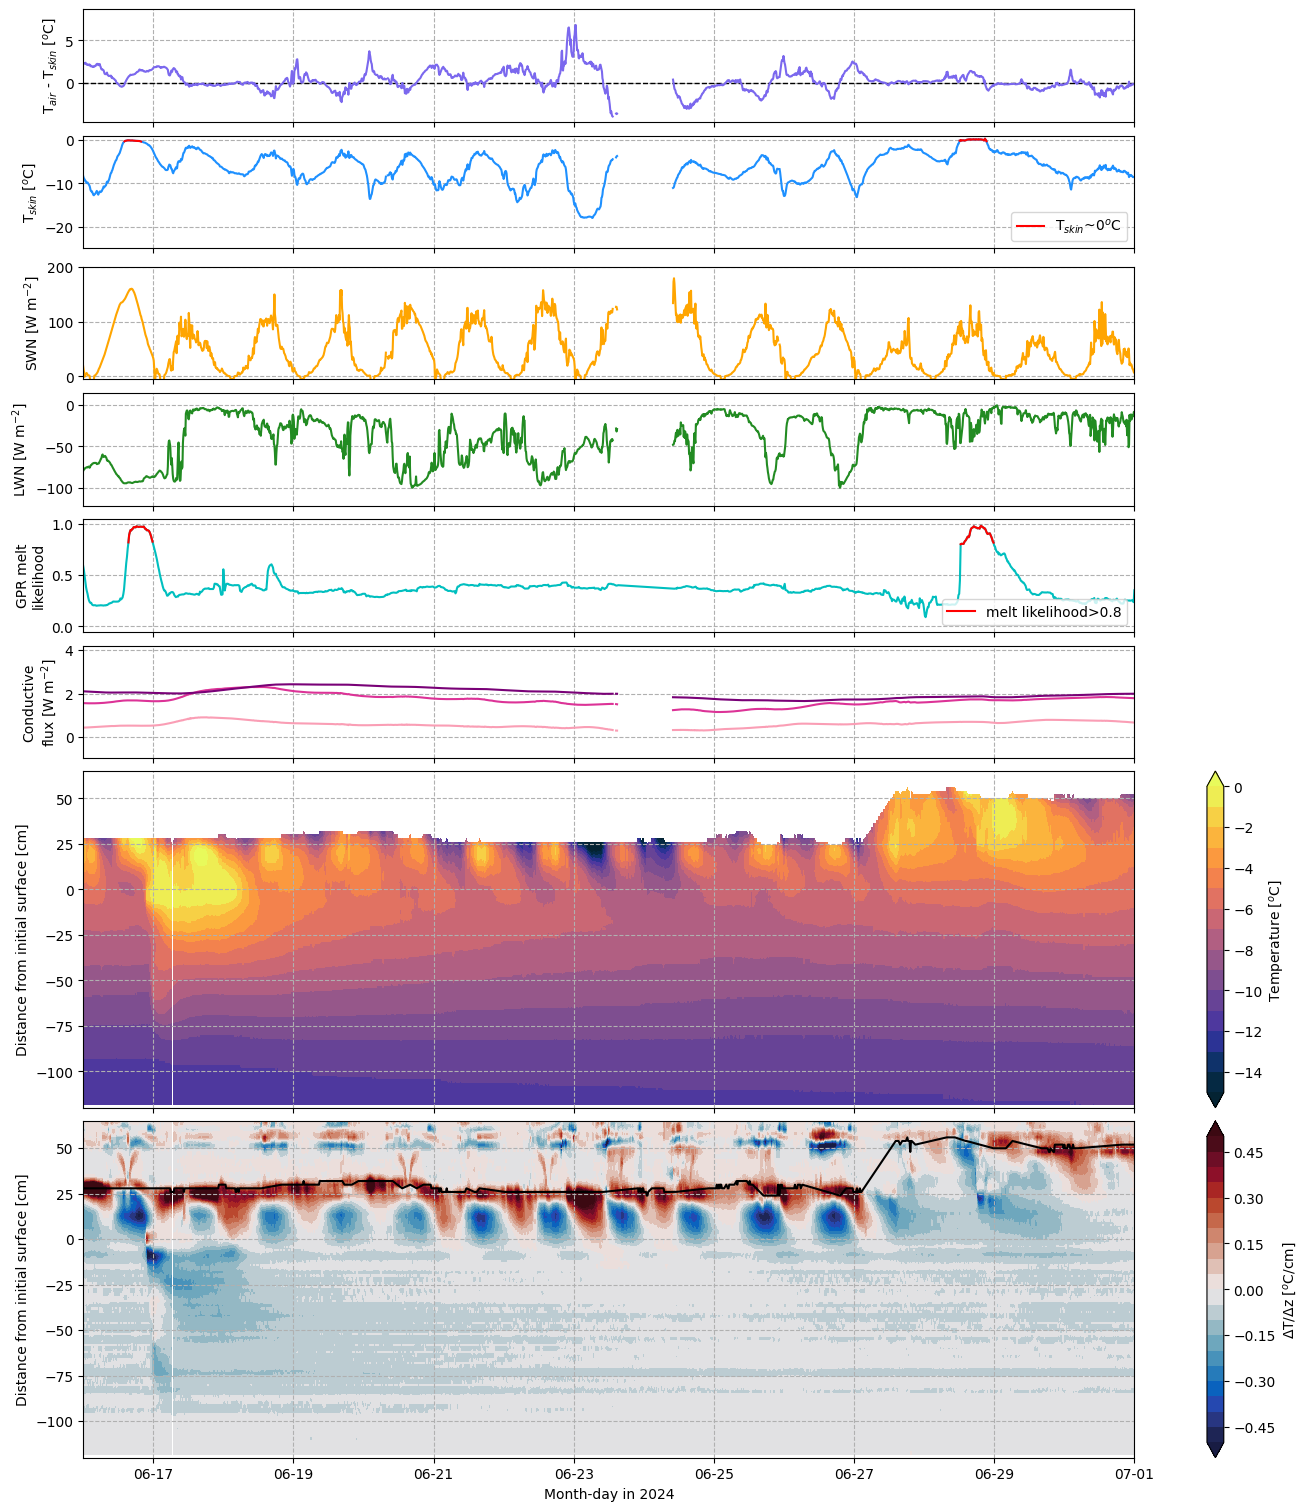

In [614]:
fig, axs = plt.subplots(8, figsize=(13,15), constrained_layout=True, 
                        sharex=True, gridspec_kw=dict(height_ratios=[1,1,1,1,1,1,3,3]))


for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp']-273.15, c='dodgerblue')
axs[1].plot(asfs_data_lev2['dates'], np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.32), c='r', label='T$_{skin}$~0$^o$C')
axs[1].set_ylabel('T$_{skin}$ [$^o$C]')

axs[0].axhline(y=0, c='k', ls='--', lw=1)
axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15), c='mediumslateblue')
axs[0].set_ylabel('T$_{air}$ - T$_{skin}$ [$^o$C]')

axs[2].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='orange')
axs[2].set_ylabel('SWN [W m$^{-2}$]')

axs[1].set_ylim(-25,1)


# axs[1].set_xlim(dt(2024,6,8),dt(2024,6,22))
axs[1].set_xlim(dt(2024,6,16),dt(2024,7,1))

axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp'], c='forestgreen')
axs[3].set_ylabel('LWN [W m$^{-2}$]')

axs[4].plot(gpr_dates, gpr_melt, c='c')
axs[4].plot(gpr_dates, np.ma.masked_less(gpr_melt,.8), c='r', label='melt likelihood>0.8')
axs[4].set_ylabel('GPR melt\nlikelihood')

for fp, c in zip(['A','B','C'],['#FA9EB5','#DC3397','#790177']):
    axs[5].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_'+fp], c=c)
axs[5].set_ylabel('Conductive\nflux [W m$^{-2}$]')


# axs[-1].plot(plt_times, 100.*rnd_sfc-32, color='gray')
# axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
# axs[-1].plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], c='c')
# axs[-1].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm')

cb = axs[-2].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(season_data_solar['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-15,0.5,1), extend='both')
# axs[1].contour(simba_dates, simba_depths, np.swapaxes(corrected_temps_new,0,1),
#                 levels=[0], extend='both')
plt.colorbar(cb, ax=axs[-2], label='Temperature [$^o$C]')


# plt.cm.BrBG
cb = axs[-1].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(temp_vert_grad_unc,0,1)/100.,
                cmap=cmocean.cm.balance, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, ax=axs[-1], label='$\Delta$T/$\Delta$z [$^o$C/cm]')
axs[-1].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='k')

for i in [-1, -2]:
    axs[i].set_ylim(-120,65)
    axs[i].set_ylabel('Distance from initial surface [cm]')

# axs[-1].plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser')
# axs[-1].plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger')

# for ogre in ['rav2_origin','rav3_west']:
#     axs[-1].plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., label='OGRE '+ogre.split('_')[-1])

for i in [1,4]:
    axs[i].legend(loc='lower right')

axs[2].set_ylim(-5,200)

axs[-1].xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')

# plt.savefig(plrams_fpath+'Raven_stacked-timeseries_July15-25_poster.png', dpi=300)

plt.show()

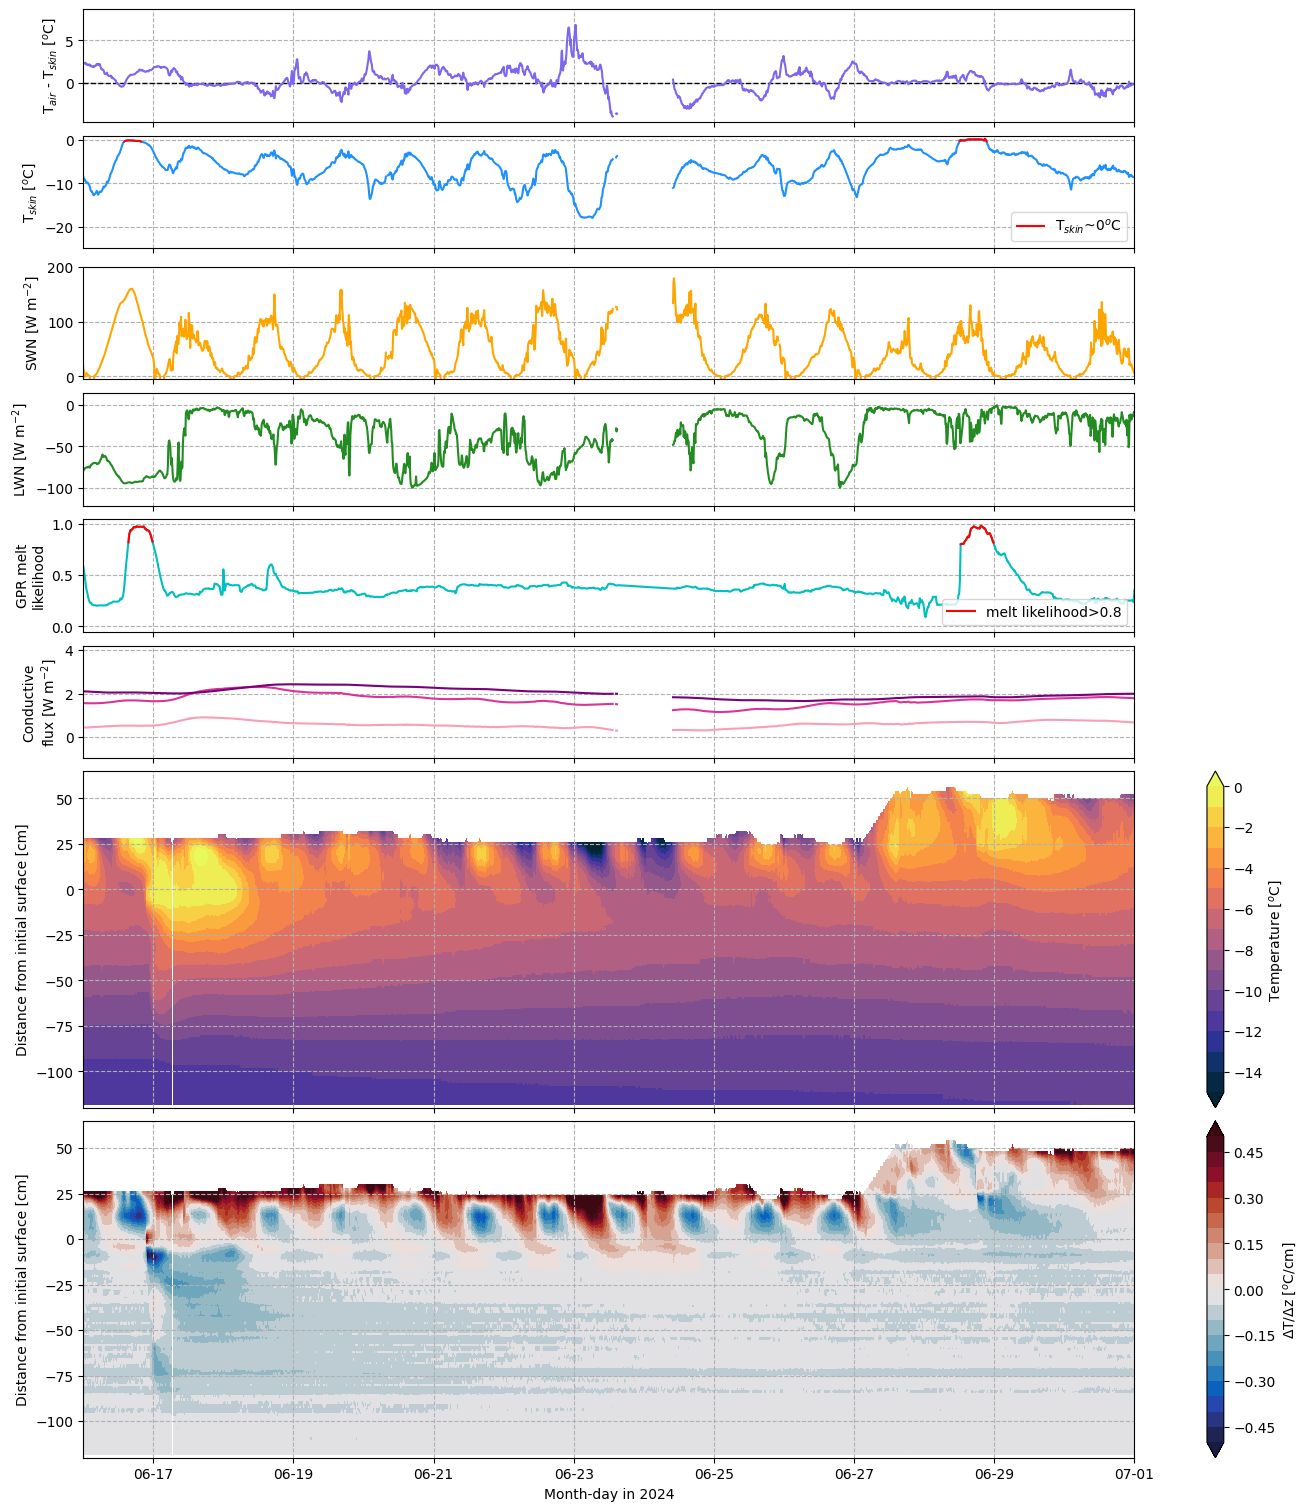

In [613]:
fig, axs = plt.subplots(8, figsize=(13,15), constrained_layout=True, 
                        sharex=True, gridspec_kw=dict(height_ratios=[1,1,1,1,1,1,3,3]))


for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp']-273.15, c='dodgerblue')
axs[1].plot(asfs_data_lev2['dates'], np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.32), c='r', label='T$_{skin}$~0$^o$C')
axs[1].set_ylabel('T$_{skin}$ [$^o$C]')

axs[0].axhline(y=0, c='k', ls='--', lw=1)
axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15), c='mediumslateblue')
axs[0].set_ylabel('T$_{air}$ - T$_{skin}$ [$^o$C]')

axs[2].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='orange')
axs[2].set_ylabel('SWN [W m$^{-2}$]')

axs[1].set_ylim(-25,1)


axs[1].set_xlim(dt(2024,6,9),dt(2024,6,19))

axs[1].set_xlim(dt(2024,6,16),dt(2024,7,1))

# axs[1].set_xlim(dt(2024,7,15),dt(2024,7,25))

axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp'], c='forestgreen')
axs[3].set_ylabel('LWN [W m$^{-2}$]')

axs[4].plot(gpr_dates, gpr_melt, c='c')
axs[4].plot(gpr_dates, np.ma.masked_less(gpr_melt,.8), c='r', label='melt likelihood>0.8')
axs[4].set_ylabel('GPR melt\nlikelihood')

for fp, c in zip(['A','B','C'],['#FA9EB5','#DC3397','#790177']):
    axs[5].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_'+fp], c=c)
axs[5].set_ylabel('Conductive\nflux [W m$^{-2}$]')


# axs[-1].plot(plt_times, 100.*rnd_sfc-32, color='gray')
# axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
# axs[-1].plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], c='c')
# axs[-1].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm')

cb = axs[-2].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(season_data_solar['temperature'],0,1),
                # cmap=cmocean.cm.thermal, levels=np.arange(-15,0.5,1), extend='both')
                cmap=cmocean.cm.thermal, levels=np.arange(-15,0.1,1), extend='both')

# axs[1].contour(simba_dates, simba_depths, np.swapaxes(corrected_temps_new,0,1),
#                 levels=[0], extend='both')
plt.colorbar(cb, ax=axs[-2], label='Temperature [$^o$C]')

cb = axs[-1].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(temp_vert_grad,0,1)/100.,
                cmap=cmocean.cm.balance, levels=np.arange(-.5,.51,.05), extend='both')

# cb = axs[-1].contourf(season_data_solar['dates'], season_data_solar['height'][:-1], np.swapaxes(temp_vert_grad_one_side,0,1)/100.,
#                 cmap=cmocean.cm.balance, levels=np.arange(-.5,.51,.05), extend='both')



plt.colorbar(cb, ax=axs[-1], label='$\Delta$T/$\Delta$z [$^o$C/cm]')

for i in [-1, -2]:
    axs[i].set_ylim(-120,65)
    axs[i].set_ylabel('Distance from initial surface [cm]')

# axs[-1].plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser')
# axs[-1].plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger')

# for ogre in ['rav2_origin','rav3_west']:
#     axs[-1].plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., label='OGRE '+ogre.split('_')[-1])

for i in [1,4]:
    axs[i].legend(loc='lower right')

axs[2].set_ylim(-5,200)

axs[-1].xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')

# plt.savefig(plrams_fpath+'Raven_stacked-timeseries_Jun10-20.png', dpi=300)

plt.show()

#### save figures to explain dT/dz concerns

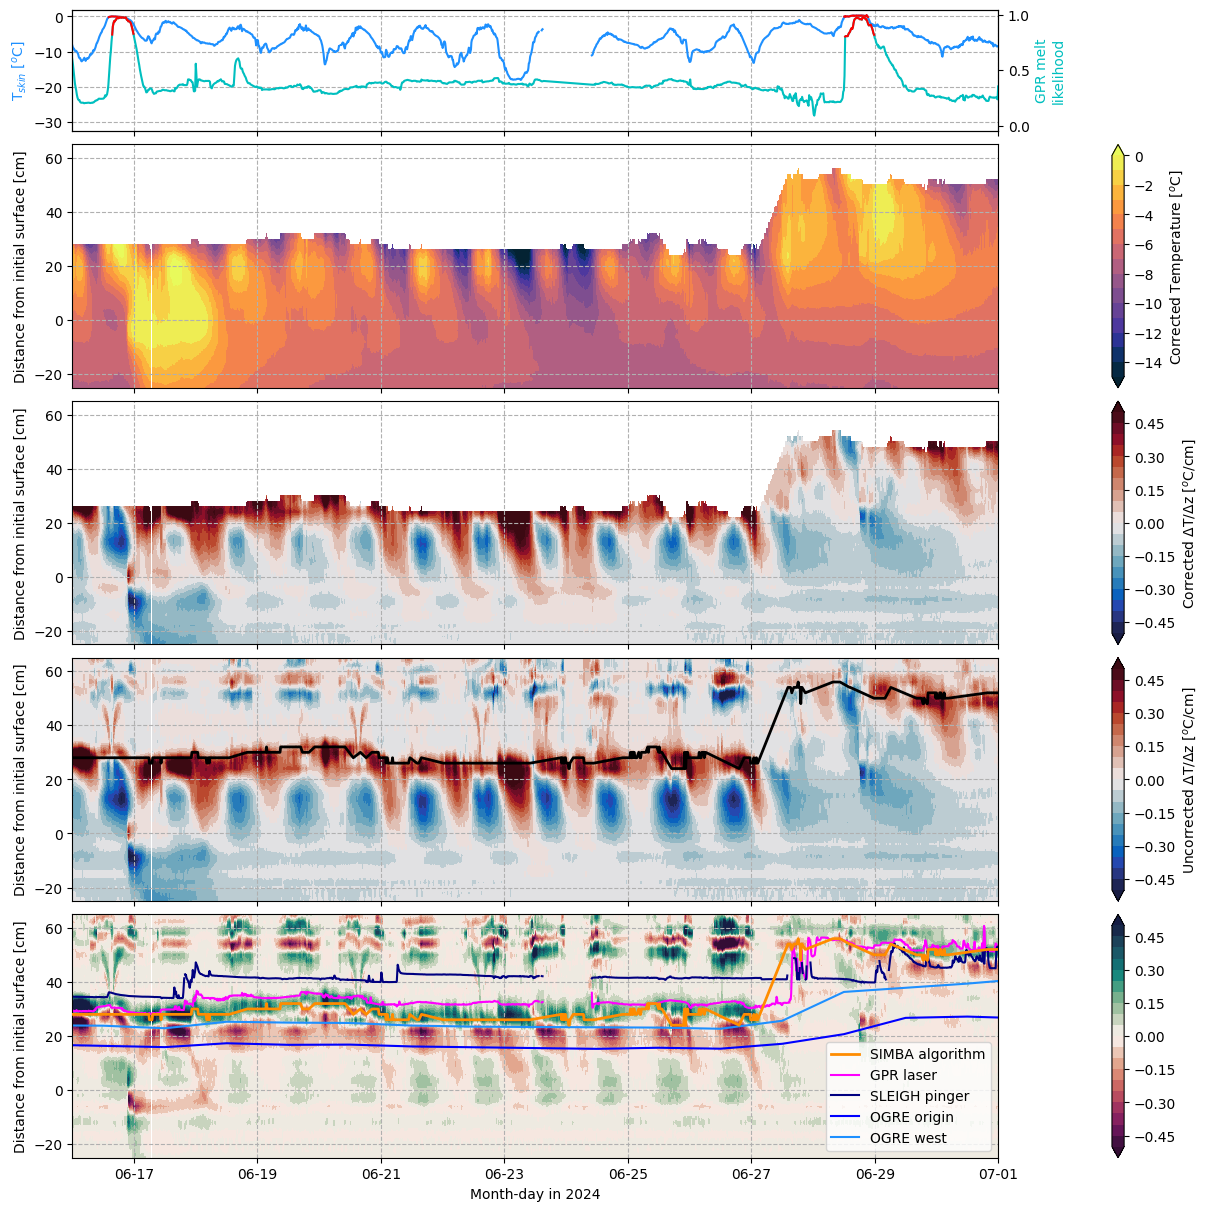

In [665]:
fig, axs = plt.subplots(5, figsize=(12,12), constrained_layout=True, 
                        sharex=True, gridspec_kw=dict(height_ratios=[1,2,2,2,2]))


for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')


axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp']-273.15, c='dodgerblue')
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.32), c='r', label='T$_{skin}$~0$^o$C')
axs[0].set_ylabel('T$_{skin}$ [$^o$C]', color='dodgerblue')

axtwin = axs[0].twinx()
axtwin.plot(gpr_dates, gpr_melt, c='c')
axtwin.plot(gpr_dates, np.ma.masked_less(gpr_melt,.8), c='r', label='melt likelihood>0.8')
axtwin.set_ylabel('GPR melt\nlikelihood', color='c')


cb = axs[1].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(season_data_solar['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-15,0.1,1), extend='both')
plt.colorbar(cb, ax=axs[1], label='Corrected Temperature [$^o$C]')

cb = axs[2].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(temp_vert_grad,0,1)/100.,
                cmap=cmocean.cm.balance, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, ax=axs[2], label='Corrected $\Delta$T/$\Delta$z [$^o$C/cm]')


cb = axs[3].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(temp_vert_grad_unc,0,1)/100.,
                cmap=cmocean.cm.balance, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, ax=axs[3], label='Uncorrected $\Delta$T/$\Delta$z [$^o$C/cm]')
axs[3].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='k', lw=2)

cmap = cmocean.cm.curl_r
cb = axs[4].contourf(season_data_unc['dates'], season_data_unc['height'], np.swapaxes(second_vert_grad,0,1),
                cmap=cmap, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, ax=axs[4], label='')

axs[4].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm', c='darkorange', lw=2, zorder=10)
axs[4].plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., 
        label='GPR laser', c='magenta')
axs[4].plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='navy')

for ogre, c in zip(['rav2_origin','rav3_west'],['b', 'dodgerblue']):
    axs[4].plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., 
            label='OGRE '+ogre.split('_')[-1], c=c)

axs[4].legend(loc='lower right')

axs[-1].xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')

# xlimit = (dt(2024,5,20),dt(2024,6,1))
xlimit = (dt(2024,6,16),dt(2024,7,1))
# xlimit = (dt(2024,7,10),dt(2024,7,25))

axs[1].set_xlim(xlimit)

for i in range(1, len(axs)):
    if xlimit==(dt(2024,5,20),dt(2024,6,1)):
        axs[i].set_ylim(-30,25)
    else:
        axs[i].set_ylim(-25,65)
    axs[i].set_ylabel('Distance from initial surface [cm]')


# axs[1].set_xlim(dt(2024,5,30),dt(2024,6,15))

# axs[1].set_xlim(dt(2024,6,16),dt(2024,7,1))
# plt.tight_layout()
savepath = '/home/asledd/ICECAPS/subsurface_reinvestigation/'
if xlimit==(dt(2024,5,20),dt(2024,6,1)):
    fname = 'Raven_Tskin-GPR_T_dTdz_d2tdz2_May20-Jun1.png'
elif xlimit==(dt(2024,6,16),dt(2024,7,1)):
    fname = 'Raven_Tskin-GPR_T_dTdz_d2tdz2_Jun16-Jul1.png'
elif xlimit==(dt(2024,7,10),dt(2024,7,25)):
    fname = 'Raven_Tskin-GPR_T_dTdz_d2tdz2_Jul10-Jul25.png'
    
# plt.savefig(savepath+fname, dpi=250)
plt.show()

## looking at warming/variability relative to the surface

In [161]:
## calculate warming over each layer
## maybe try to calculate energy accumulated? make some assumptions for density based on snow pits and new snow density...

In [162]:
print(season_data['dates'][-1], season_data_solar['dates'][-1])
sfc_idx = np.where( (season_data['dates']>=season_data_solar['dates'][0])&(season_data['dates']<=season_data_solar['dates'][-1]) )

2024-08-14 23:45:00 2024-07-24 23:45:00


In [163]:
depths_rel_to_sfc = np.repeat(season_data_solar['height'].copy()[np.newaxis,:], season_data_solar['temperature'].shape[0], axis=0)

sfc_2d = np.ma.repeat(simba_sfc[sfc_idx[0],np.newaxis], season_data_solar['temperature'].shape[1], axis=1)
depths_rel_to_sfc = depths_rel_to_sfc-sfc_2d

In [164]:
temporary_temp = np.ma.masked_where(depths_rel_to_sfc>0, season_data_solar['temperature'])# temporary temperature

temps_rel_to_sfc = []

m = 100 # size of 

for i in range(temporary_temp.shape[0]):
    temp_i = temporary_temp[i,:-1]
    sub_t = temp_i[~temp_i.mask]

    sub_t_filled = np.ma.concatenate( (sub_t, np.full(int(m-sub_t.count()), -999 )) )
    temps_rel_to_sfc.append(sub_t_filled)
    
temps_rel_to_sfc = np.ma.masked_equal(temps_rel_to_sfc, -999)

In [165]:
sub_depths = np.arange(0,temps_rel_to_sfc.shape[1])
sub_depths *= -2

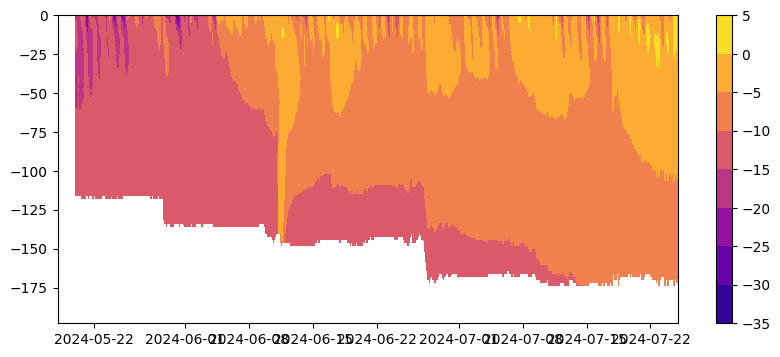

In [166]:
fig, axs = plt.subplots(1, figsize=(10,4))

cb = plt.contourf(season_data_solar['dates'], sub_depths, np.swapaxes(temps_rel_to_sfc,0,1), cmap='plasma')
# plt.plot(simba_dates, simba_sfc-6.,  c='k')
plt.colorbar(cb)

# plt.xlim(dt(2024,6,8),dt(2024,6,15))
plt.show()

In [167]:
temps_rel_to_sfc = np.ma.masked_invalid(temps_rel_to_sfc)

In [168]:
temp_counts = temps_rel_to_sfc.count(axis=0)

## std dev w/ depth
temp_std_profile = temps_rel_to_sfc.std(axis=0)

l = temps_rel_to_sfc.count(axis=0)[0]
temp_std_full = np.ma.masked_where(temp_counts<l, temp_std_profile)


## correlations to surface/skin temperature w/ depth
temp_corrs = np.ma.corrcoef(temps_rel_to_sfc[:,0], temps_rel_to_sfc[:,1:].T)[0][1:]
# temp_corrs_skin = np.ma.corrcoef(skinT_sfc_timesteps, temps_rel_to_sfc[:,:].T)[0][1:]

# warming relative to surface - also test warming at each level?
dT_dt_rel_to_sfc = temps_rel_to_sfc[1:,:] - temps_rel_to_sfc[:-1,:]
dT_dt_rel_to_sfc = dT_dt_rel_to_sfc.sum(axis=0)

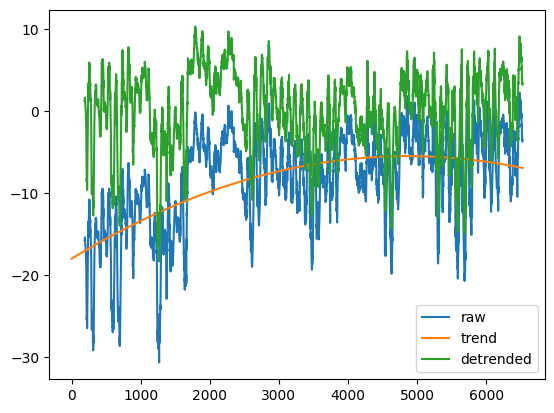

In [169]:
# detrend_temps = scipy.signal.detrend(temps_rel_to_sfc, axis=0)

# detrend_temps = detrend_masked_along_axis(temps_rel_to_sfc, axis=0, type='linear')
# detrend_temps = []


# ## inefficent detrending because there are nans

x = np.arange(temps_rel_to_sfc.shape[0])

slopes_with_depth = []

for i in range(temps_rel_to_sfc.shape[1]):
    y = temps_rel_to_sfc[:,i]

    try:
        coeff = np.ma.polyfit(x, y, 2)
    except:
        detrend_temps = np.ma.concatenate( (detrend_temps, np.full(x.shape, np.nan)[:, np.newaxis]), axis=1 )
        slopes_with_depth.append(np.nan)
        continue
    # no need to use the original x values here just for visualizing the polynomial
    x_poly = np.linspace(x.min(), x.max())
    y_poly = np.polyval(coeff, x_poly)
    
    # we need the original x values here, so we can remove the trend from all points
    trend = np.polyval(coeff, x)
    t_detrend = y - trend
    # note that simply subtracting the trend might not be enough for other data sets
    slopes_with_depth.append(coeff[0])
        
    if i==0:
        detrend_temps = t_detrend[:, np.newaxis]
        ## check detrending
        plt.plot(x, y, label='raw')
        plt.plot(x, trend, label='trend')
        plt.plot(x, t_detrend, label='detrended')
        plt.legend(loc='best')
        plt.show()

    else:
        detrend_temps = np.ma.concatenate( (detrend_temps, t_detrend[:, np.newaxis]), axis=1 )

    # print(i, coeff[0])


detrend_temps = np.ma.masked_invalid(detrend_temps)

# fig, axs = plt.subplots(3, figsize=(10,12))

# cb = axs[0].contourf(season_data_solar['dates'], sub_depths, np.swapaxes(temps_rel_to_sfc,0,1), cmap='plasma', levels=np.arange(-20,0.1,2))
# plt.colorbar(cb, ax=axs[0])

# cb = axs[1].contourf(season_data_solar['dates'], sub_depths, np.swapaxes(detrend_temps,0,1), cmap='plasma', levels=np.arange(-20,0.1,2),
#                     extend='both')
# # plt.plot(simba_dates, simba_sfc-6.,  c='k')
# plt.colorbar(cb, ax=axs[1])

# cb = axs[2].contourf(season_data_solar['dates'], sub_depths, np.swapaxes(detrend_temps-temps_rel_to_sfc,0,1), cmap=cmocean.cm.speed)
# plt.colorbar(cb, ax=axs[2])

# # plt.xlim(dt(2024,6,8),dt(2024,6,15))
# plt.show()

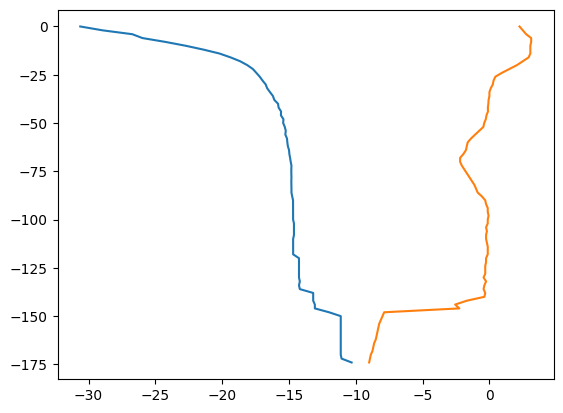

In [170]:
plt.plot(temps_rel_to_sfc.min(axis=0), sub_depths)
plt.plot(temps_rel_to_sfc.max(axis=0), sub_depths)

In [171]:
detrend_corr = np.ma.corrcoef(detrend_temps[:,0], detrend_temps[:,1:].T)[0][1:]


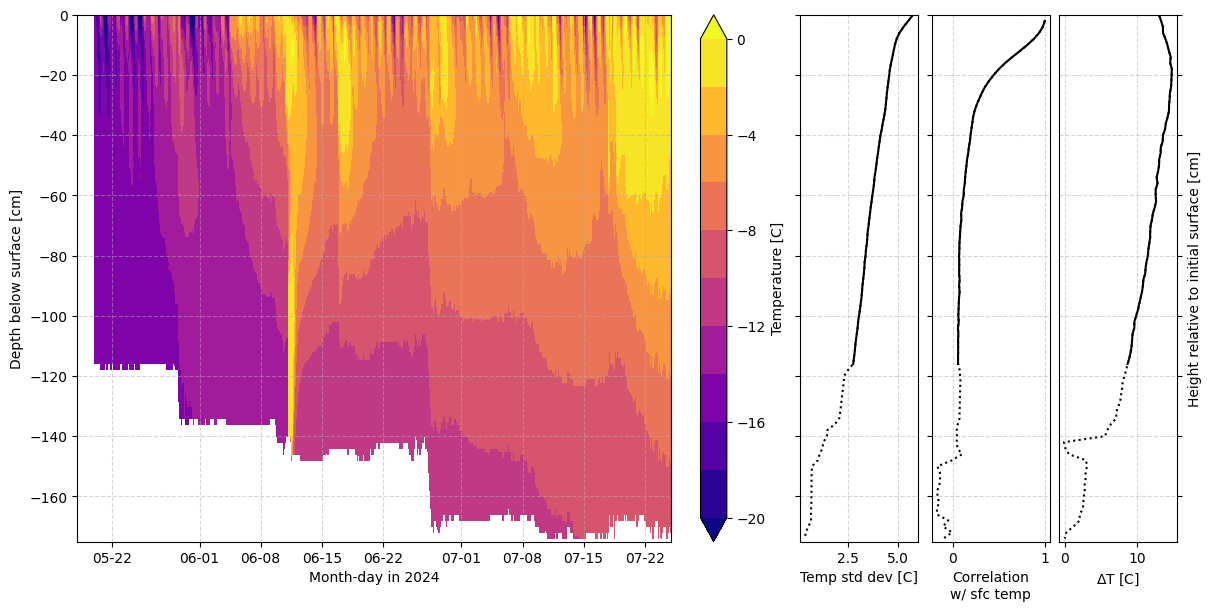

In [172]:
fig, axs = plt.subplots(1,4, figsize=(12,6), sharey=True, 
                        gridspec_kw=dict(width_ratios=[5,1,1,1]), constrained_layout=True)

cb = axs[0].contourf(season_data_solar['dates'], sub_depths, np.swapaxes(temps_rel_to_sfc,0,1), cmap='plasma',
                    levels=np.arange(-20,0.1,2), extend='both')
plt.colorbar(cb, label='Temperature [C]', ax=axs[0])

labels = ['Temp std dev [C]','Correlation\nw/ sfc temp','$\Delta$T [C]']
# for i, (ax, var) in enumerate(zip(axs.ravel()[1:], [temp_std_profile, temp_corrs, dT_dt_rel_to_sfc])):
for i, (ax, var) in enumerate(zip(axs.ravel()[1:], [temp_std_profile, detrend_corr, dT_dt_rel_to_sfc])):

    # print(var)
    if i==1:
        ax.plot(var, sub_depths[1:],ls=':', c='k')
        ax.plot(detrend_corr[~temp_std_full[1:].mask], sub_depths[1:][~temp_std_full[1:].mask], c='k')
    else:
        ax.plot(var, sub_depths, ls=':', c='k')
        ax.plot(var[~temp_std_full.mask], sub_depths[~temp_std_full.mask], c='k')

    ax.set_xlabel(labels[i])
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylabel('Depth below surface [cm]')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_xlabel('Month-day in 2024')

axs[-1].yaxis.set_label_position("right")
axs[-1].yaxis.tick_right()
axs[-1].set_ylabel('Height relative to initial surface [cm]')

axs[0].set_ylim(-175,0)
axs[0].grid(alpha=.5, ls='--')
plt.show()

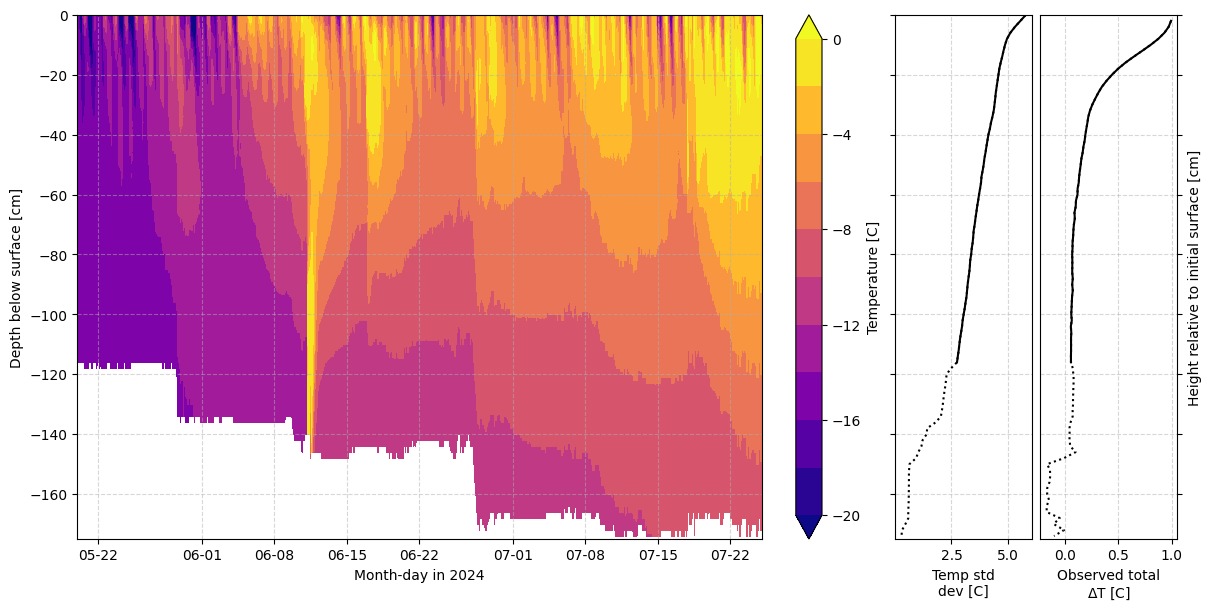

In [173]:
fig, axs = plt.subplots(1,3, figsize=(12,6), sharey=True, 
                        gridspec_kw=dict(width_ratios=[5,1,1]), constrained_layout=True)

cb = axs[0].contourf(season_data_solar['dates'], sub_depths, np.swapaxes(temps_rel_to_sfc,0,1), cmap='plasma',
                    levels=np.arange(-20,0.1,2), extend='both')
plt.colorbar(cb, label='Temperature [C]', ax=axs[0])

labels = ['Temp std\ndev [C]','Observed total\n$\Delta$T [C]']
# for i, (ax, var) in enumerate(zip(axs.ravel()[1:], [temp_std_profile, temp_corrs, dT_dt_rel_to_sfc])):
for i, (ax, var) in enumerate(zip(axs.ravel()[1:], [temp_std_profile, detrend_corr, dT_dt_rel_to_sfc])):

    # print(var)
    if i==1:
        ax.plot(var, sub_depths[1:],ls=':', c='k')
        ax.plot(detrend_corr[~temp_std_full[1:].mask], sub_depths[1:][~temp_std_full[1:].mask], c='k')
    else:
        ax.plot(var, sub_depths, ls=':', c='k')
        ax.plot(var[~temp_std_full.mask], sub_depths[~temp_std_full.mask], c='k')

    ax.set_xlabel(labels[i])
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylabel('Depth below surface [cm]')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_xlabel('Month-day in 2024')

axs[-1].yaxis.set_label_position("right")
axs[-1].yaxis.tick_right()
axs[-1].set_ylabel('Height relative to initial surface [cm]')

axs[0].set_xlim(dt(2024,5,20),dt(2024,7,25))
axs[0].set_ylim(-175,0)
axs[0].grid(alpha=.5, ls='--')
# plt.savefig(plrams_fpath+'SIMBA_corrected_temps-rel-to-sfc.png', dpi=300)
plt.show()

Is lag correlation just showing the dirunal cycle at the surface? 

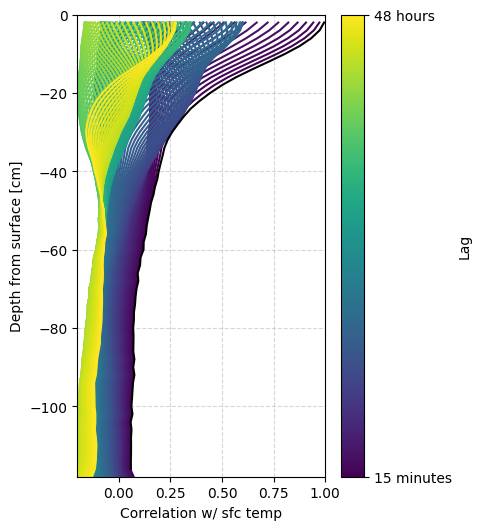

In [174]:
fig, ax = plt.subplots(1, figsize=(4,6))

max_lag = 3*24*4
for lag in range(0,max_lag+1,2):
    if lag==0:
        lagged_corrs = detrend_corr[np.newaxis,:]
        continue
    # print(lag)
    detrend_corr_lag = np.ma.corrcoef(detrend_temps[lag:,0], detrend_temps[:-lag,1:].T)[0][1:]

    lagged_corrs = np.ma.concatenate( (lagged_corrs, detrend_corr_lag[np.newaxis,:]), axis=0)
    
    col = plt.cm.viridis(lag/max_lag)

    plt.plot(detrend_corr_lag, sub_depths[1:], c=col)

plt.plot(detrend_corr[~temp_std_full[1:].mask], sub_depths[1:][~temp_std_full[1:].mask], c='k')

cmappable = ScalarMappable(norm=Normalize(0,1), cmap=plt.cm.viridis)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, ticks=np.arange(0, 2), label='Lag', ax=ax)
cbar.ax.set_yticklabels(['15 minutes','48 hours'])

plt.ylabel('Depth from surface [cm]')
plt.xlabel('Correlation w/ sfc temp')
plt.ylim(-118,0)
plt.xlim(-.2,1)
plt.grid(alpha=.5, ls='--')
# plt.savefig('Raven_temp-lag-corr_rel-to-sfc.png', dpi=250)
plt.show()

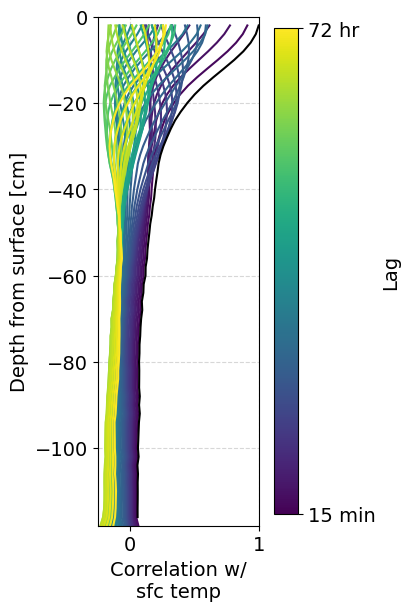

In [125]:
fig, ax = plt.subplots(1, figsize=(4,6), constrained_layout=True)

max_lag = 3*24*4
for lag in range(0,max_lag+1,6):
    if lag==0:
        lagged_corrs_sparse = detrend_corr[np.newaxis,:]
        continue
    # print(lag)
    detrend_corr_lag = np.ma.corrcoef(detrend_temps[lag:,0], detrend_temps[:-lag,1:].T)[0][1:]

    lagged_corrs_sparse = np.ma.concatenate( (lagged_corrs_sparse, detrend_corr_lag[np.newaxis,:]), axis=0)
    
    col = plt.cm.viridis(lag/max_lag)

    plt.plot(detrend_corr_lag, sub_depths[1:], c=col)

plt.plot(detrend_corr[~temp_std_full[1:].mask], sub_depths[1:][~temp_std_full[1:].mask], c='k')

cmappable = ScalarMappable(norm=Normalize(0,1), cmap=plt.cm.viridis)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, ticks=np.arange(0, 2), label='Lag', ax=ax)
cbar.ax.set_yticklabels(['15 min','72 hr'])

plt.ylabel('Depth from surface [cm]')
plt.xlabel('Correlation w/\nsfc temp')
plt.ylim(-118,0)
plt.xlim(-.25,1)
plt.grid(alpha=.5, ls='--')
# plt.savefig(plrams_fpath+'Raven_temp-lag-corr_rel-to-sfc_72hr-total_6hr-steps.png', dpi=250)
plt.show()

In [39]:
print(max_lag)

288


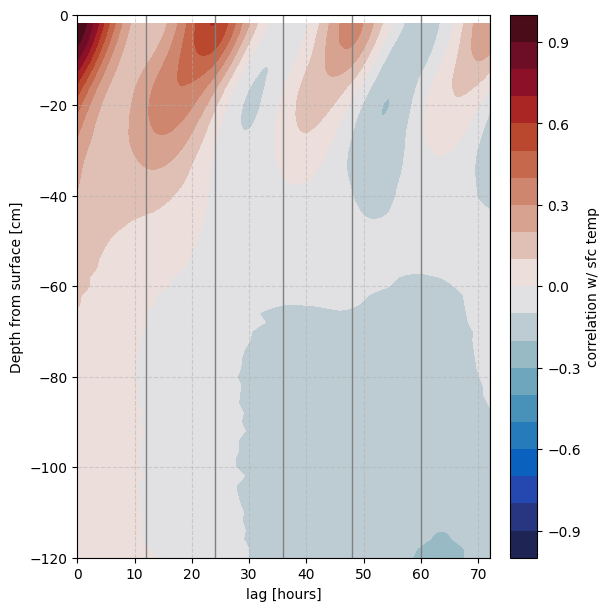

In [175]:
fig, ax = plt.subplots(1, figsize=(6,6), constrained_layout=True)
cb = plt.contourf(np.arange(0,max_lag+1,2)*15/60., sub_depths[1:], np.swapaxes(lagged_corrs,0,1),
                 levels=np.linspace(-1,1,21), cmap=cmocean.cm.balance)
plt.colorbar(cb, label='correlation w/ sfc temp')
plt.ylabel('Depth from surface [cm]')
plt.xlabel('lag [hours]')
plt.ylim(-120,0)
plt.grid(alpha=.5, ls='--')

for a in range(12,73,12):
    plt.axvline(x=a, c='gray', lw=1)
# plt.savefig('Raven_lagg-corrs_dpth-from-sfc_contour_72-hours.png', dpi=250)
# plt.savefig(plrams_fpath+'SIMBA_corrected_temp-correlations-rel-to-sfcT.png', dpi=300)

plt.show()


In [49]:
from numpy.fft import fft, ifft


In [54]:
def corr_np(data1, data2, a=0):
    mean1 = data1.mean(axis=a) 
    mean2 = data2.mean(axis=a)
    std1 = data1.std(axis=a)
    std2 = data2.std(axis=a)
    corr = ((data1*data2).mean(axis=a)-mean1*mean2)/(std1*std2)
    return corr

In [56]:
lag  = 2
# corr_at_depth = fft(detrend_temps, axis=1)
corr_at_depth = corr_np(detrend_temps[1:,:], detrend_temps[:-1,:])
print(corr_at_depth)

[0.9920632628470392 0.9927783539984398 0.993625715465999
 0.9942095271661573 0.994565711472024 0.9949279737619314
 0.9953099017347318 0.9956656670137713 0.9959887031240212
 0.9963675775850644 0.9965125317777647 0.9967015532010316
 0.9967268802676724 0.9968184946488916 0.996908224932684
 0.9969031954205109 0.9969214772856065 0.9969708144789065
 0.9970703614519401 0.997131661945735 0.9973086856011381 0.997427274297303
 0.9975849859185343 0.9977582434690396 0.998014798494315
 0.9981514762724886 0.9982920237651495 0.9985231778299712
 0.9986794019305265 0.9987513542020975 0.9987904719997021
 0.9988269317807866 0.9988878034514499 0.998982291660998 0.999004413076043
 0.9989755070422612 0.9990424877666946 0.9987888672590343
 0.9989890600301354 0.9989280873112671 0.9989149836312373
 0.9989805055134695 0.9988292387711222 0.998755591760062
 0.9985601555146111 0.9984320261789363 0.9979387630552733
 0.9976760011719953 0.9973636862530955 0.9965680241833678
 0.9965049891699111 0.9967028614107717 0.99

In [176]:
# For Michael: lagged correlations at each depth

max_lag = 3*24*4
# max_lag = 4*4
step = 2
for lag in range(0,max_lag+1,step):
    if lag==0:
        continue

    detrend_corr_lag = corr_np(detrend_temps[lag:,:], detrend_temps[:-lag,:])
    if lag==step:
        lagged_corrs_at_depth = detrend_corr_lag[np.newaxis,:]
    else:
        lagged_corrs_at_depth = np.ma.concatenate( (lagged_corrs_at_depth, detrend_corr_lag[np.newaxis,:]), axis=0)
    


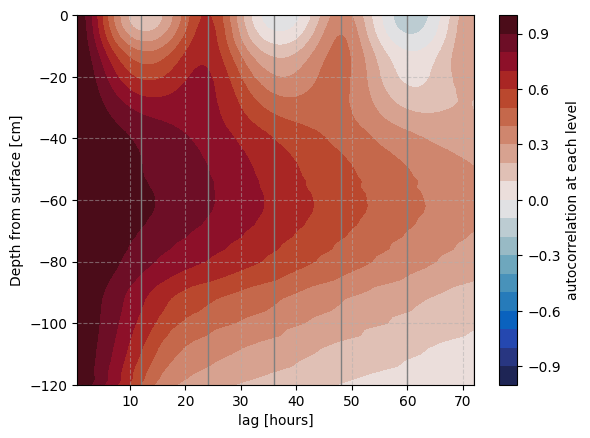

In [177]:
cb = plt.contourf(np.arange(0,max_lag+1,2)[1:]*15/60., sub_depths[:], np.swapaxes(lagged_corrs_at_depth,0,1),
                 levels=np.linspace(-1,1,21), cmap=cmocean.cm.balance)
plt.colorbar(cb, label='autocorrelation at each level')
plt.ylabel('Depth from surface [cm]')
plt.xlabel('lag [hours]')
plt.ylim(-120,0)
plt.grid(alpha=.5, ls='--')

for a in range(12,73,12):
    plt.axvline(x=a, c='gray', lw=1)
plt.savefig('Raven_lagg-autocorrs_dpth-from-sfc_contour_72-hours.png', dpi=250)
plt.show()

Average diurnal cycles?

In [ ]:
season_data_solar['dates'], sub_depths, np.swapaxes(temps_rel_to_sfc,0,1)

In [340]:
simba_hours = np.array([d.hour for d in season_data_solar['dates']])
simba_mins = np.array([d.minute for d in season_data_solar['dates']])

## time of day
simba_tod = simba_hours+simba_mins/60.

In [341]:
print(np.unique(simba_tod))

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75]


In [408]:
daily_avgs = np.array([temps_rel_to_sfc[np.where(simba_tod==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])
daily_std = np.array([temps_rel_to_sfc[np.where(simba_tod==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])

daily_avgs_dTdz = np.array([grads_rel_to_sfc[np.where(simba_tod==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])


## these dates are somewhat arbitrary at the moment - should be more carefully chosen!
begin_idx = np.where(season_data_solar['dates']<dt(2024,6,9))[0]
daily_avgs_beginning = np.array([temps_rel_to_sfc[begin_idx,:][np.where(simba_tod[begin_idx]==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])
daily_std_beginning = np.array([temps_rel_to_sfc[begin_idx,:][np.where(simba_tod[begin_idx]==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])
daily_dTdz_beginning = np.array([grads_rel_to_sfc[begin_idx,:][np.where(simba_tod[begin_idx]==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])

end_idx = np.where(season_data_solar['dates']>dt(2024,7,1))[0]
daily_avgs_end = np.array([temps_rel_to_sfc[end_idx,:][np.where(simba_tod[end_idx]==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])
daily_std_end = np.array([temps_rel_to_sfc[end_idx,:][np.where(simba_tod[end_idx]==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])
daily_dTdz_end = np.array([grads_rel_to_sfc[end_idx,:][np.where(simba_tod[end_idx]==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])

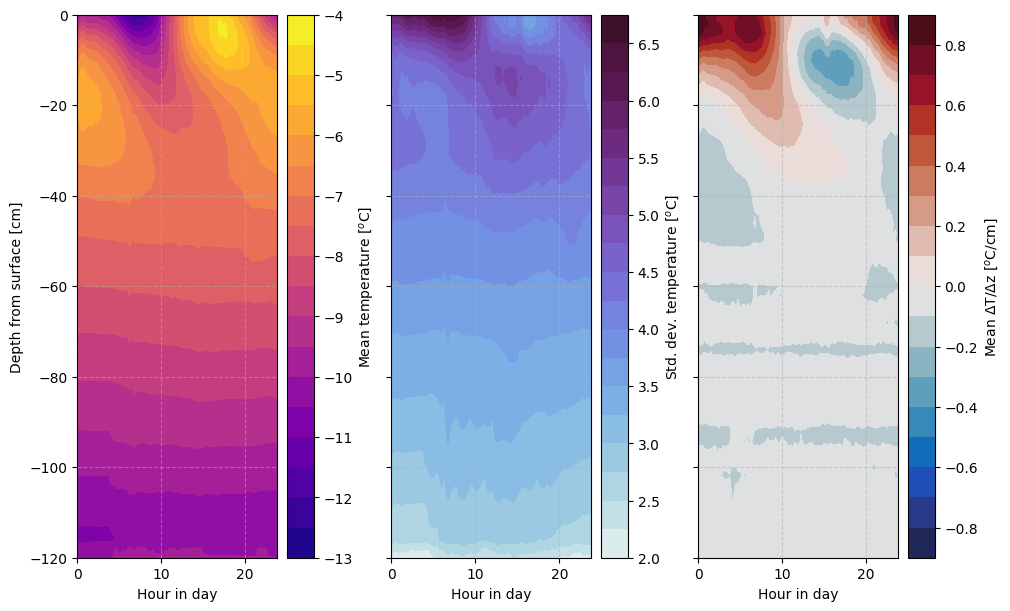

In [406]:
fig, axs = plt.subplots(1,3, figsize=(10,6), constrained_layout=True, sharey=True)

cbar_labels = ['Mean temperature [$^o$C]', 'Std. dev. temperature [$^o$C]', 'Mean $\Delta$T/$\Delta$z [$^o$C/cm]']
levels = [np.arange(-13,-3.6,.5), np.arange(2,7,.25), np.arange(-.9,.91,.1)]
cmaps = [plt.cm.plasma, cmocean.cm.dense, cmocean.cm.balance]

for i, (ax, var) in enumerate(zip(axs.ravel(), [daily_avgs, daily_std, daily_avgs_dTdz])):
    cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i])
    plt.colorbar(cb, label=cbar_labels[i], ax=ax)

    ax.set_ylim(-120,0)
    
    ax.set_xlabel('Hour in day')
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylabel('Depth from surface [cm]')
# plt.tight_layout()
plt.show()

/tmp/ipykernel_42094/1771002205.py:10: UserWarning: The following kwargs were not used by contour: 'exend'
  cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i], exend='both')


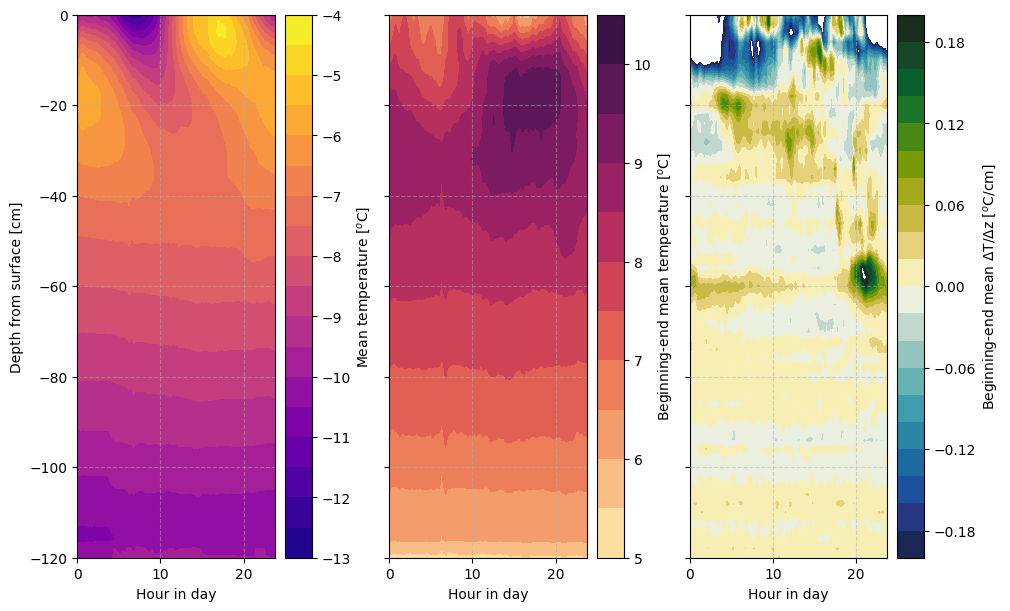

In [424]:
fig, axs = plt.subplots(1,3, figsize=(10,6), constrained_layout=True, sharey=True)

cbar_labels = ['Mean temperature [$^o$C]', 'Beginning-end mean temperature [$^o$C]', 'Beginning-end mean $\Delta$T/$\Delta$z [$^o$C/cm]']
levels = [np.arange(-13,-3.6,.5), np.arange(5,11,.5), np.arange(-0.2,0.21,.02)]
cmaps = [plt.cm.plasma, cmocean.cm.matter, cmocean.cm.delta]
extends = [None, None, 'both']

for i, (ax, var) in enumerate(zip(axs.ravel(), [daily_avgs, daily_avgs_end-daily_avgs_beginning, daily_dTdz_end-daily_dTdz_beginning])):
    if i== 2:
        cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i], exend='both')
    else:
        cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i])

    plt.colorbar(cb, label=cbar_labels[i], ax=ax)

    ax.set_ylim(-120,0)
    
    ax.set_xlabel('Hour in day')
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylabel('Depth from surface [cm]')
# plt.tight_layout()
plt.show()

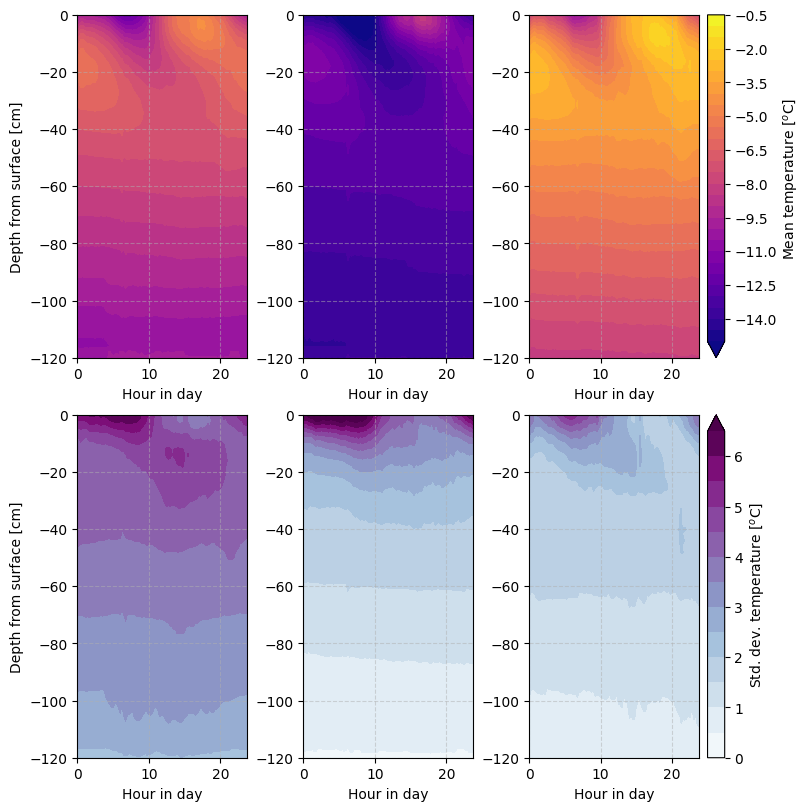

In [425]:
fig, axs = plt.subplots(2,3, figsize=(8,8), constrained_layout=True)

cbar_labels = ['Mean temperature [$^o$C]', 'Std. dev. temperature [$^o$C]']
levels = [np.arange(-15,0,.5), np.arange(0,7,.5)]
cmaps = [plt.cm.plasma, plt.cm.BuPu]
extends = ['min','max']

subtitles = ['Full season', 'Before June 9, 2024', 'After July 1, 2024']

all_data = [[daily_avgs, daily_avgs_beginning, daily_avgs_end], [daily_std, daily_std_beginning, daily_std_end]]

for i, dataset in enumerate(all_data):
    for j, var in enumerate(dataset):
    
        cb = axs[i][j].contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], extend=extends[i], cmap=cmaps[i])
        if j==2:
            plt.colorbar(cb, label=cbar_labels[i], ax=axs[i][j])
    
        axs[i][j].set_ylim(-120,0)
        
        axs[i][j].set_xlabel('Hour in day')
        axs[i][j].grid(alpha=.5, ls='--')

    axs[i][0].set_ylabel('Depth from surface [cm]')
# plt.tight_layout()
plt.show()

#### comparing uncorrected mean, std dev, and dT/dz

In [483]:
unc_idx = np.where( (season_data_unc['dates']>=season_data_solar['dates'][0])&(season_data_unc['dates']<=season_data_solar['dates'][-1]) )[0]

In [486]:
unc_temps = season_data_unc['temperature'][unc_idx,:]

In [487]:
temporary_temp_unc = np.ma.masked_where(depths_rel_to_sfc>0, unc_temps)# temporary temperature

temps_rel_to_sfc_unc = []

m = 100 # size of 

for i in range(temporary_temp_unc.shape[0]):
    temp_i = temporary_temp_unc[i,:-1]
    sub_t = temp_i[~temp_i.mask]

    sub_t_filled = np.ma.concatenate( (sub_t, np.full(int(m-sub_t.count()), -999 )) )
    temps_rel_to_sfc_unc.append(sub_t_filled)
    
temps_rel_to_sfc_unc = np.ma.masked_equal(temps_rel_to_sfc_unc, -999)

In [488]:
grads_rel_to_sfc_unc =  np.gradient(temps_rel_to_sfc_unc, axis=1)

In [489]:
daily_avgs_unc = np.array([temps_rel_to_sfc_unc[np.where(simba_tod==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])
daily_std_unc = np.array([temps_rel_to_sfc_unc[np.where(simba_tod==t)[0],:].std(axis=0) for t in np.unique(simba_tod)])

daily_avgs_dTdz_unc = np.array([grads_rel_to_sfc_unc[np.where(simba_tod==t)[0],:].mean(axis=0) for t in np.unique(simba_tod)])

0
1


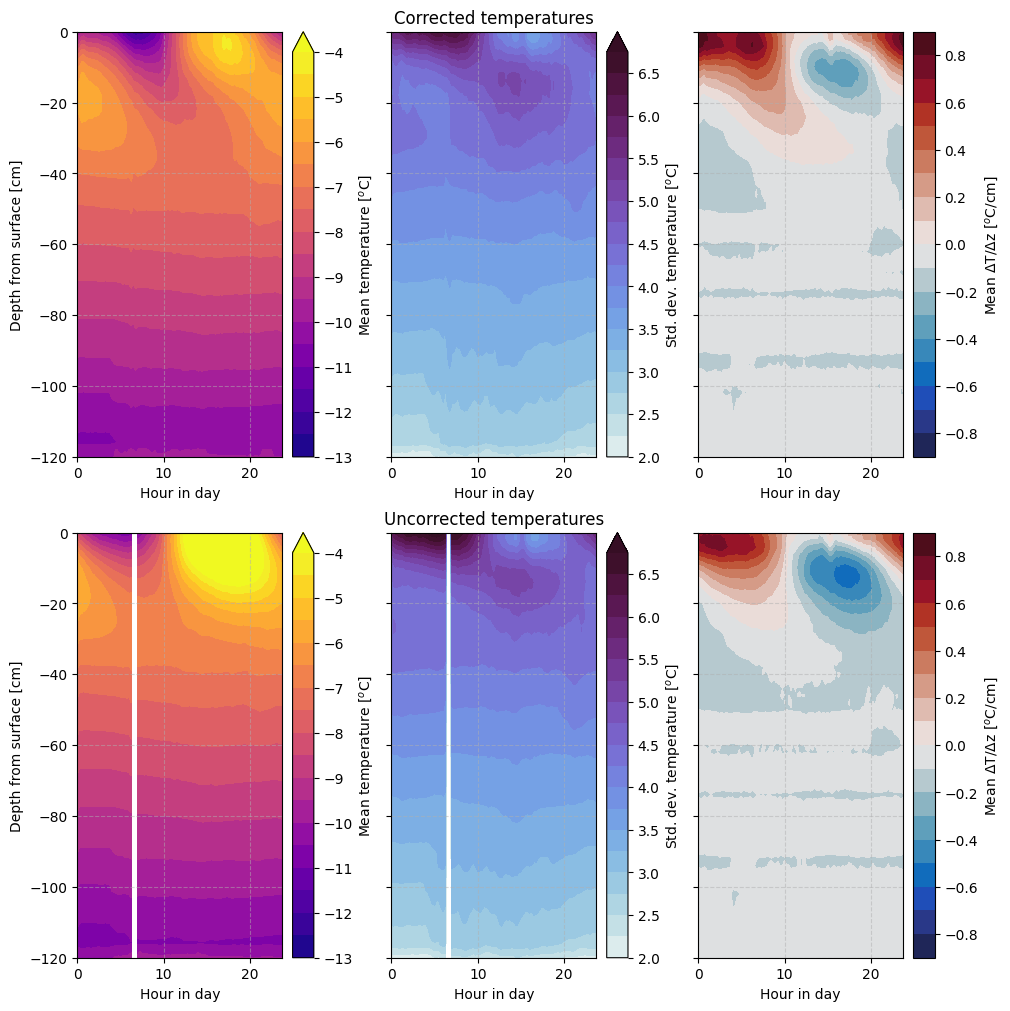

In [502]:
fig, axs = plt.subplots(2,3, figsize=(10,10), constrained_layout=True, sharey=True)

cbar_labels = ['Mean temperature [$^o$C]', 'Std. dev. temperature [$^o$C]', 'Mean $\Delta$T/$\Delta$z [$^o$C/cm]']
levels = [np.arange(-13,-3.6,.5), np.arange(2,7,.25), np.arange(-.9,.91,.1)]
cmaps = [plt.cm.plasma, cmocean.cm.dense, cmocean.cm.balance]

suptitles = ['Corrected temperatures', 'Uncorrected temperatures']

for j, datasets in enumerate([[daily_avgs, daily_std, daily_avgs_dTdz],[daily_avgs_unc, daily_std_unc, daily_avgs_dTdz_unc]]):

    for i, var in enumerate(datasets):
        if i<2:
            cb = axs[j][i].contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i], extend='max')
        else:
            cb = axs[j][i].contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=levels[i], cmap=cmaps[i])
    
        plt.colorbar(cb, label=cbar_labels[i], ax=axs[j][i])
    
        axs[j][i].set_ylim(-120,0)
        
        axs[j][i].set_xlabel('Hour in day')
        axs[j][i].grid(alpha=.5, ls='--')
    axs[j][1].set_title(suptitles[j])
    axs[j][0].set_ylabel('Depth from surface [cm]')


# plt.tight_layout()
plt.show()

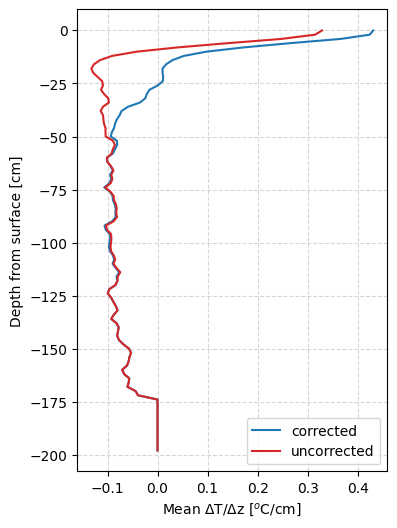

In [505]:
plt.figure(figsize=(4,6))

plt.plot(daily_avgs_dTdz.mean(axis=0), sub_depths, label='corrected')
plt.plot(daily_avgs_dTdz_unc.mean(axis=0), sub_depths, label='uncorrected', c='tab:red')
plt.grid(alpha=.5, ls='--')
plt.xlabel('Mean $\Delta$T/$\Delta$z [$^o$C/cm]')
plt.ylabel('Depth from surface [cm]')
plt.legend(loc='best')

plt.show()

#### Melt vs nonmelt days?

In [542]:
# simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in season_data['dates']])
gpr_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in gpr_dates])

f_gpr = interpolate.interp1d(gpr_seconds, gpr_melt, fill_value=-999, bounds_error=False)
gpr_simba_dates = f_gpr(simba_seconds)
gpr_simba_dates = np.ma.masked_equal(gpr_simba_dates, -999)

In [657]:
melty_dates = np.ma.masked_where(gpr_simba_dates<0.8, season_data_solar['dates'])
melty_day_mn = np.unique([' '.join((str(d.day), str(d.month))) for d in melty_dates[~melty_dates.mask]])
all_day_mn = np.asarray([' '.join((str(d.day), str(d.month))) for d in season_data_solar['dates']])


In [658]:
## inefficient but whatever
simba_melty_idx = np.zeros(season_data_solar['dates'].shape)

for md in melty_day_mn:
    # print(md, np.where(all_day_mn==md))
    
    simba_melty_idx[np.where(all_day_mn==md)] = 1

# print(np.unique(all_day_mn[np.where(simba_melty_idx==1)]))

In [659]:
print('# of melty days: ', len(melty_day_mn))
print('# of non-melty days: ', len(np.unique(all_day_mn[np.where(simba_melty_idx==0)[0]]))),
print('# of all days: ', len(np.unique(all_day_mn)))

# of melty days:  20
# of non-melty days:  48
# of all days:  68


In [660]:
grads_rel_to_sfc_dry = grads_rel_to_sfc[np.where(simba_melty_idx==0)[0],:]
dry_simba_tod = simba_tod[np.where(simba_melty_idx==0)[0]]
daily_avgs_dTdz_dry = np.array([grads_rel_to_sfc_dry[np.where(dry_simba_tod==t)[0],:].mean(axis=0) for t in np.unique(dry_simba_tod)])

grads_rel_to_sfc_melty = grads_rel_to_sfc[np.where(simba_melty_idx==1)[0],:]
melty_simba_tod = simba_tod[np.where(simba_melty_idx==1)[0]]
daily_avgs_dTdz_melty = np.array([grads_rel_to_sfc_melty[np.where(melty_simba_tod==t)[0],:].mean(axis=0) for t in np.unique(melty_simba_tod)])

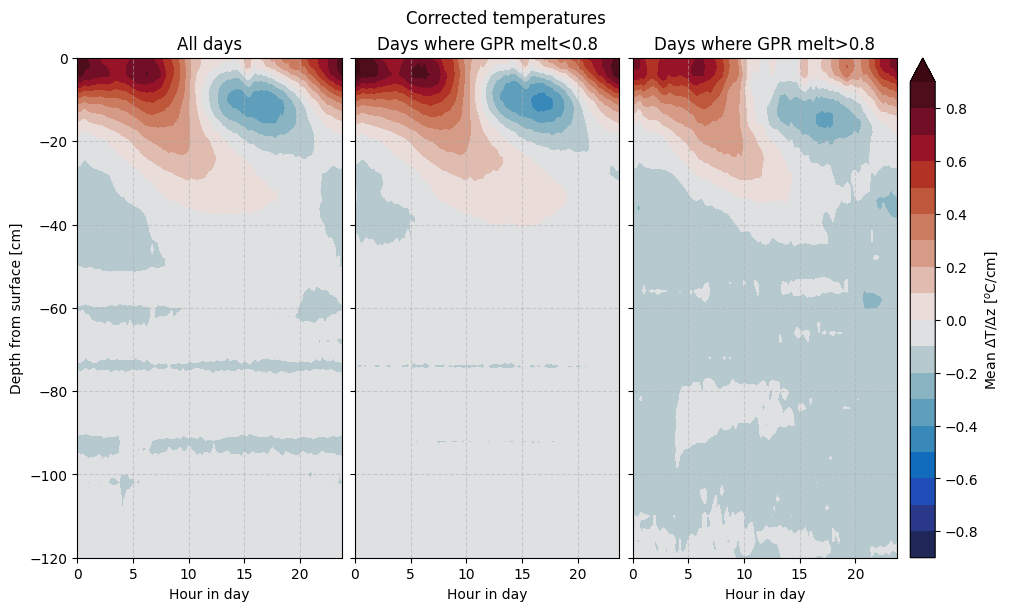

In [661]:
fig, axs = plt.subplots(1,3, figsize=(10,6), constrained_layout=True, sharey=True)

subtitles = ['All days', 'Days where GPR melt<0.8', 'Days where GPR melt>0.8']


for i, (ax, var) in enumerate(zip(axs.ravel(), [daily_avgs_dTdz, daily_avgs_dTdz_dry, daily_avgs_dTdz_melty])):
    cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=np.arange(-.9,.91,.1), 
                     cmap=cmocean.cm.balance, extend='max')
    

    ax.set_ylim(-120,0)
    ax.set_title(subtitles[i])
    ax.set_xlabel('Hour in day')
    ax.grid(alpha=.5, ls='--')

plt.colorbar(cb, label='Mean $\Delta$T/$\Delta$z [$^o$C/cm]', ax=axs[-1])

axs[0].set_ylabel('Depth from surface [cm]')
fig.suptitle('Corrected temperatures')
# plt.tight_layout()
plt.show()

In [662]:
grads_rel_to_sfc_dry_unc = grads_rel_to_sfc_unc[np.where(simba_melty_idx==0)[0],:]
dry_simba_tod = simba_tod[np.where(simba_melty_idx==0)[0]]
daily_avgs_dTdz_dry_unc = np.array([grads_rel_to_sfc_dry_unc[np.where(dry_simba_tod==t)[0],:].mean(axis=0) for t in np.unique(dry_simba_tod)])

grads_rel_to_sfc_melty_unc = grads_rel_to_sfc_unc[np.where(simba_melty_idx==1)[0],:]
melty_simba_tod = simba_tod[np.where(simba_melty_idx==1)[0]]
daily_avgs_dTdz_melty_unc = np.array([grads_rel_to_sfc_melty_unc[np.where(melty_simba_tod==t)[0],:].mean(axis=0) for t in np.unique(melty_simba_tod)])

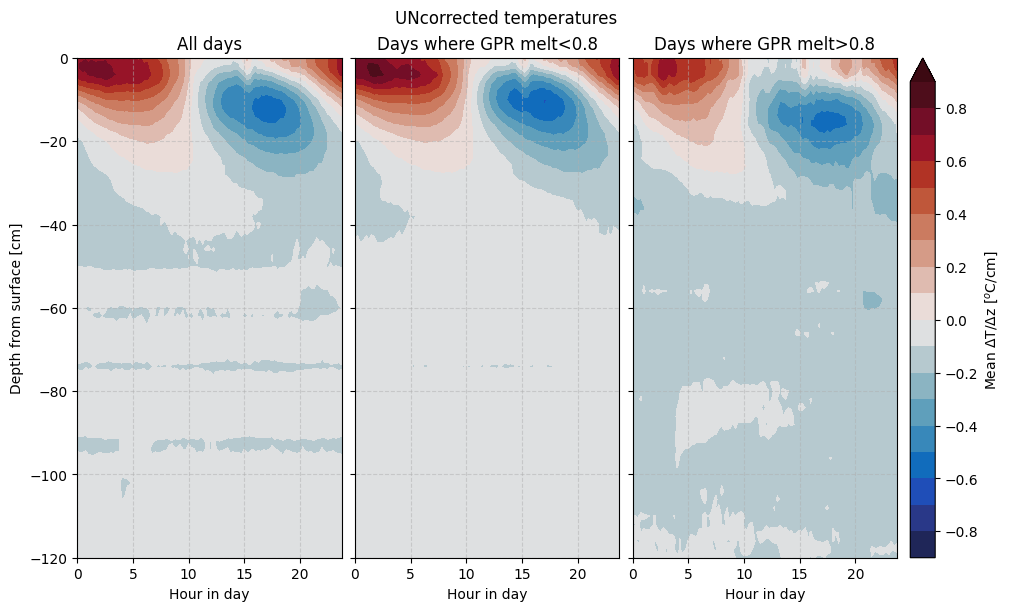

In [663]:
fig, axs = plt.subplots(1,3, figsize=(10,6), constrained_layout=True, sharey=True)

subtitles = ['All days', 'Days where GPR melt<0.8', 'Days where GPR melt>0.8']


for i, (ax, var) in enumerate(zip(axs.ravel(), [daily_avgs_dTdz_unc, daily_avgs_dTdz_dry_unc, daily_avgs_dTdz_melty_unc])):
    cb = ax.contourf(np.unique(simba_tod), sub_depths, np.swapaxes(var,0,1), levels=np.arange(-.9,.91,.1), 
                     cmap=cmocean.cm.balance, extend='max')
    

    ax.set_ylim(-120,0)
    ax.set_title(subtitles[i])
    ax.set_xlabel('Hour in day')
    ax.grid(alpha=.5, ls='--')

plt.colorbar(cb, label='Mean $\Delta$T/$\Delta$z [$^o$C/cm]', ax=axs[-1])

axs[0].set_ylabel('Depth from surface [cm]')
fig.suptitle('UNcorrected temperatures')
# plt.tight_layout()
plt.show()

## Relative to SIMBA not surface

In [178]:
simba_temperature = np.ma.masked_invalid(season_data_solar['temperature'].copy())
dT_dt_rel_to_simba = simba_temperature[1:,:] - simba_temperature[:-1,:]
dT_dt_rel_to_simba = dT_dt_rel_to_simba.sum(axis=0)

In [179]:
simba_temp_masked = np.ma.masked_outside(np.ma.masked_invalid(season_data_solar['temperature']), -50,5)
simba_dTdt = simba_temp_masked[1:,:] - simba_temp_masked[:-1,:]

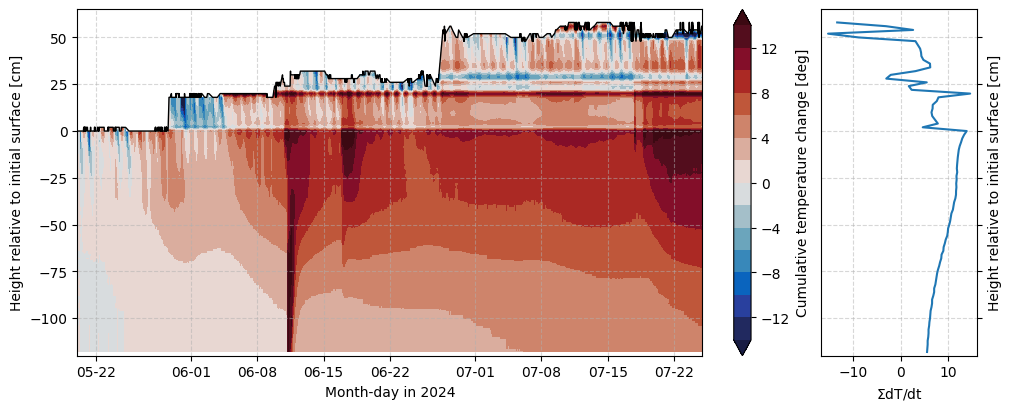

In [180]:
fig, axs =plt.subplots(1,2, figsize=(10,4), gridspec_kw=dict(width_ratios=[4,1]), constrained_layout=True, sharey=True)

cumul_temp = np.ma.cumsum(simba_dTdt, axis=0)

cb = axs[0].contourf(season_data_solar['dates'][:-1], season_data_solar['height'], np.swapaxes(cumul_temp,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-14,14.1,2.), extend='both')
axs[0].plot(season_data['dates'], simba_sfc, c='k', lw=1)

plt.colorbar(cb, label='Cumulative temperature change [deg]', ax=axs[0])
axs[0].set_ylim(-120,65)
axs[0].set_xlim(dt(2024,5,20), dt(2024,7,25))

axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_xlabel('Month-day in 2024')
axs[0].set_ylabel('Height relative to initial surface [cm]')
axs[0].grid(alpha=.5, ls='--')


axs[1].plot(dT_dt_rel_to_simba, season_data_solar['height'], c='tab:blue')
axs[1].set_xlabel('$\Sigma$dT/dt')
axs[1].grid(alpha=.5, ls='--')

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('Height relative to initial surface [cm]')

# axs[1].set_ylabel('Height relative to initial surface [cm]')

plt.show()


Temperature gradients:

In [181]:
temp_vert_grad = np.gradient(simba_temp_masked, axis=1)

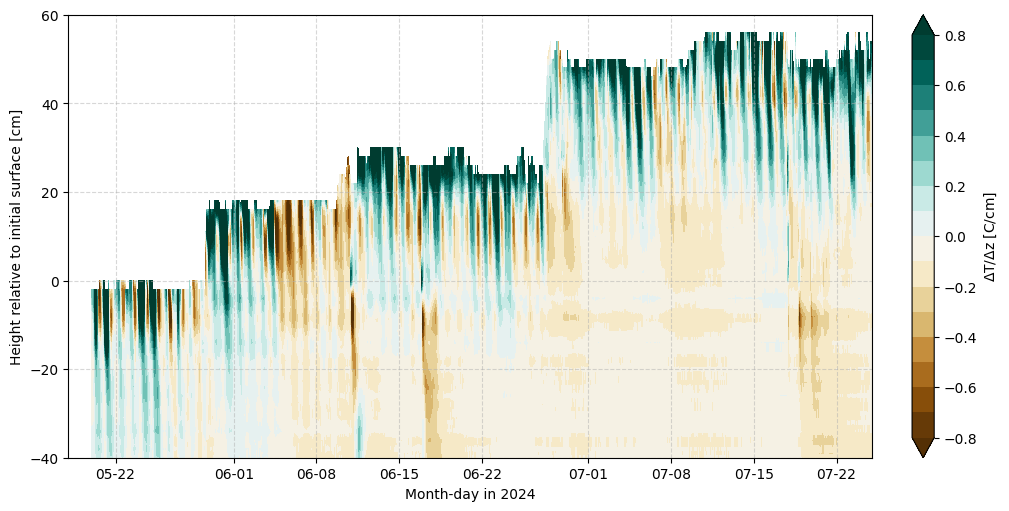

In [291]:
fig, ax = plt.subplots(1, figsize=(10,5), constrained_layout=True)

cb = ax.contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(temp_vert_grad,0,1),
                cmap=plt.cm.BrBG, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='$\Delta$T/$\Delta$z [C/cm]')

ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
ax.set_ylabel('Height relative to initial surface [cm]')
ax.grid(alpha=.5, ls='--')
# ax.set_ylim(-120,60)
ax.set_ylim(-40,60)

plt.show()

### starting to look at comparisons of melt events

In [224]:
asfs_data_lev2['net_lw'] = asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp']
asfs_data_lev2['net_sw'] = asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['net_rad'] = asfs_data_lev2['net_lw']+asfs_data_lev2['net_sw']

In [245]:
asfs_data_lev2['T2m_Tskin'] = asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15)

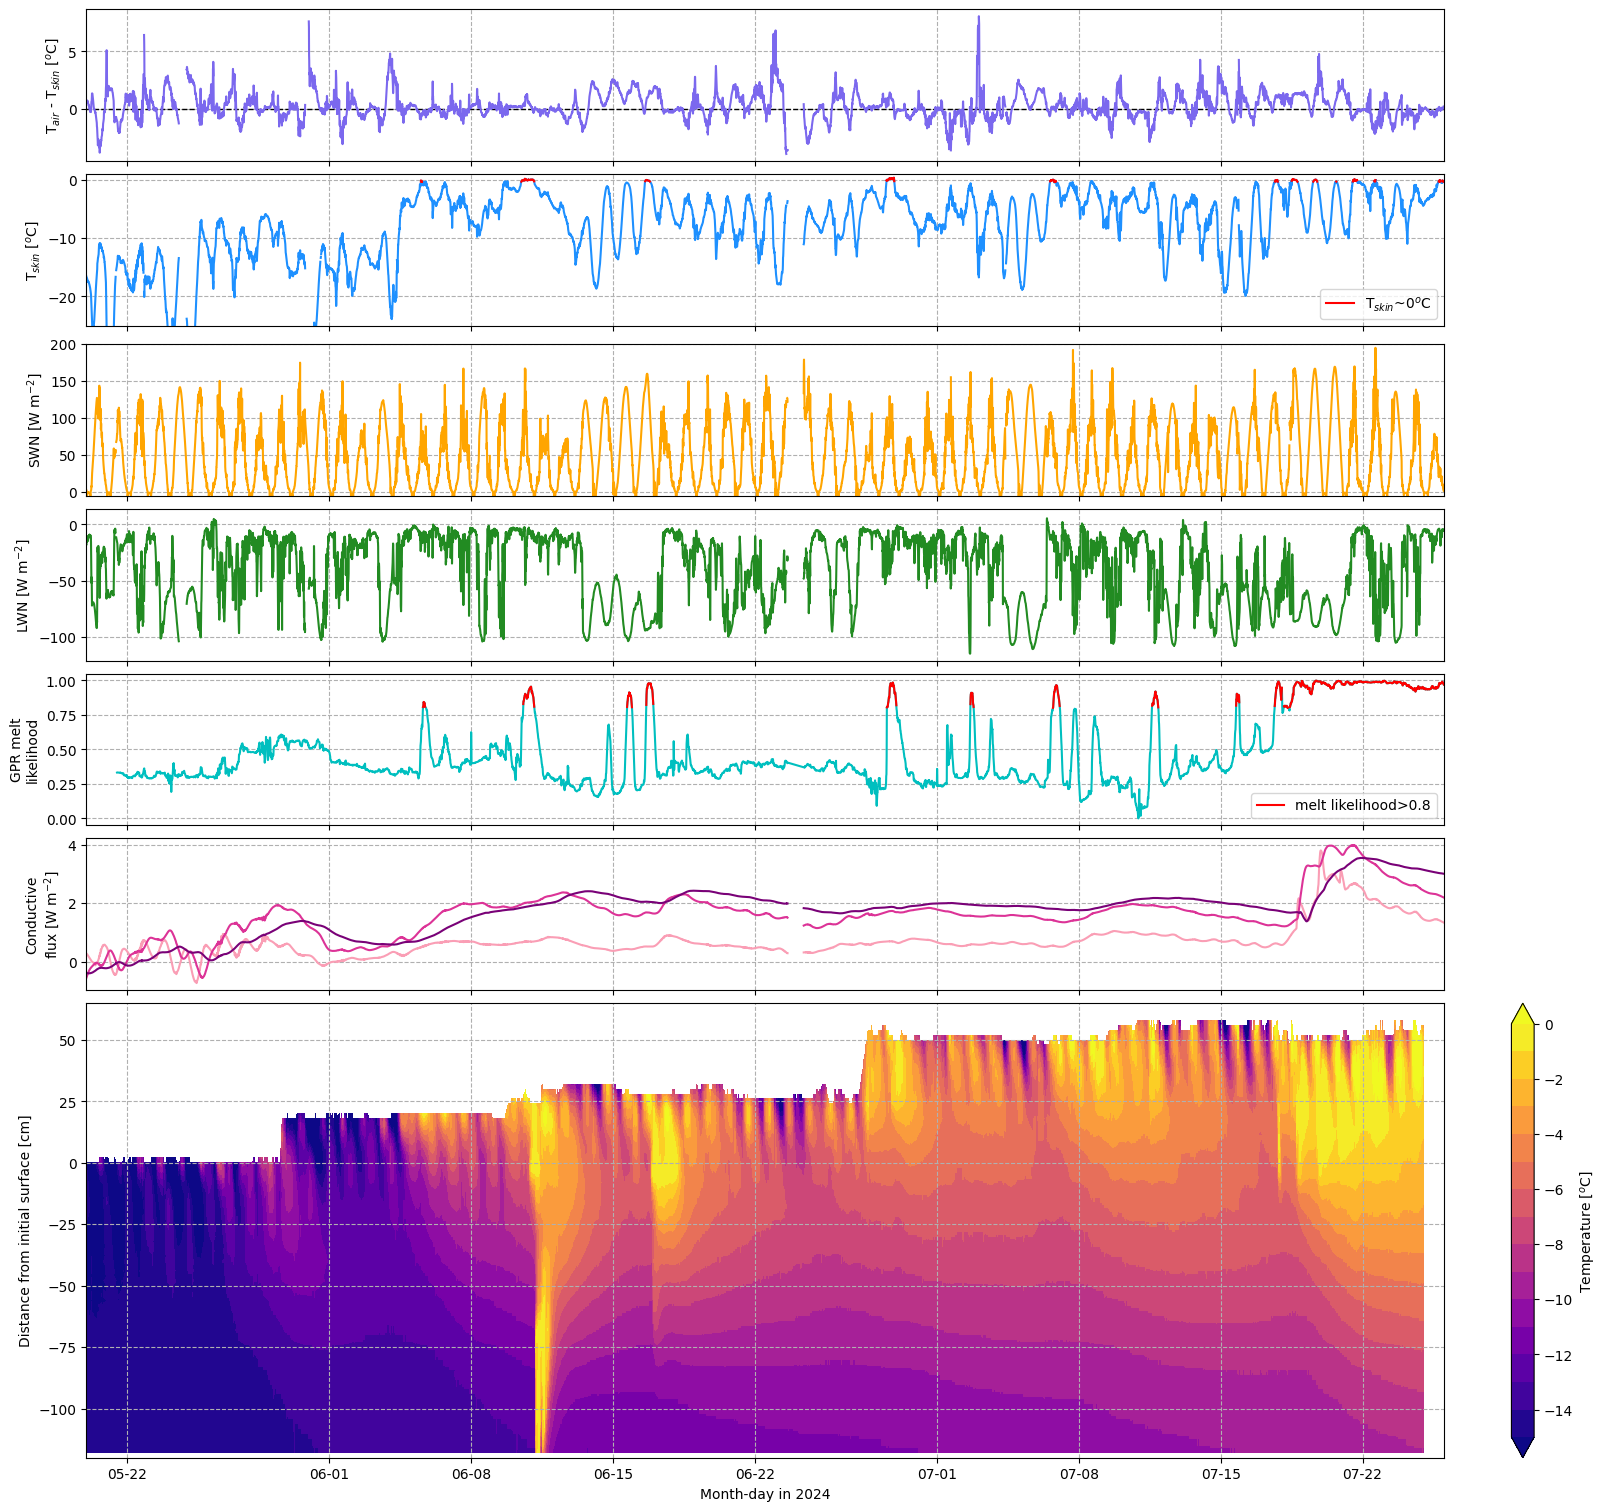

In [407]:
fig, axs = plt.subplots(7, figsize=(16,15), constrained_layout=True, 
                        sharex=True, gridspec_kw=dict(height_ratios=[1,1,1,1,1,1,3]))


for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['skin_temp']-273.15, c='dodgerblue')
axs[1].plot(asfs_data_lev2['dates'], np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.32), c='r', label='T$_{skin}$~0$^o$C')
axs[1].set_ylabel('T$_{skin}$ [$^o$C]')

axs[0].axhline(y=0, c='k', ls='--', lw=1)
axs[0].plot(asfs_data_lev2['dates'], asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15), c='mediumslateblue')
axs[0].set_ylabel('T$_{air}$ - T$_{skin}$ [$^o$C]')

axs[2].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='orange')
axs[2].set_ylabel('SWN [W m$^{-2}$]')

axs[1].set_ylim(-25,1)


# axs[1].set_xlim(dt(2024,6,8),dt(2024,6,22))
axs[1].set_xlim(dt(2024,5,20),dt(2024,7,26))

axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp'], c='forestgreen')
axs[3].set_ylabel('LWN [W m$^{-2}$]')

axs[4].plot(gpr_dates, gpr_melt, c='c')
axs[4].plot(gpr_dates, np.ma.masked_less(gpr_melt,.8), c='r', label='melt likelihood>0.8')
axs[4].set_ylabel('GPR melt\nlikelihood')

for fp, c in zip(['A','B','C'],['#FA9EB5','#DC3397','#790177']):
    axs[5].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_'+fp], c=c)
axs[5].set_ylabel('Conductive\nflux [W m$^{-2}$]')


# axs[-1].plot(plt_times, 100.*rnd_sfc-32, color='gray')
# axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
# axs[-1].plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], c='c')
# axs[-1].plot(season_data['dates'], simba_sfc, label='SIMBA algorithm')

cb = axs[-1].contourf(season_data_solar['dates'], season_data_solar['height'], np.swapaxes(season_data_solar['temperature'],0,1),
                cmap=plt.cm.plasma, levels=np.arange(-15,0.5,1), extend='both')
# axs[1].contour(simba_dates, simba_depths, np.swapaxes(corrected_temps_new,0,1),
#                 levels=[0], extend='both')
plt.colorbar(cb, ax=axs[-1], label='Temperature [$^o$C]')

axs[-1].set_ylim(-120,65)
axs[-1].set_ylabel('Distance from initial surface [cm]')

# axs[-1].plot( asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser')
# axs[-1].plot( asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger')

# for ogre in ['rav2_origin','rav3_west']:
#     axs[-1].plot(ogre_surface[ogre]['dates'], (ogre_surface[ogre]['sfc'][0]-ogre_surface[ogre]['sfc'])*100., label='OGRE '+ogre.split('_')[-1])

for i in [1,4]:
    axs[i].legend(loc='lower right')

axs[2].set_ylim(-5,200)

axs[-1].xaxis.set_major_formatter(myFmt)
axs[-1].set_xlabel('Month-day in 2024')

# plt.savefig('Raven_stacked-timeseries_may20-jul26_poster.png', dpi=350)

plt.show()

In [201]:
tksin_melt_idx = np.ma.where(((asfs_data_lev2['skin_temp']-273.15)>=-0.32)&(asfs_data_lev2['dates']<datetime.datetime(2024,7,26)))[0]

sleigh_days = np.array([sleigh_date.day for sleigh_date in asfs_data_lev2['dates']])
sleigh_months = np.array([sleigh_date.month for sleigh_date in asfs_data_lev2['dates']])
sleigh_hours = np.array([sleigh_date.hour for sleigh_date in asfs_data_lev2['dates']])

for item in asfs_data_lev2['dates'][tksin_melt_idx]:
    print(item)

2024-06-05 12:30:00
2024-06-05 12:40:00
2024-06-05 13:20:00
2024-06-05 13:30:00
2024-06-05 13:40:00
2024-06-05 18:20:00
2024-06-09 15:40:00
2024-06-09 16:50:00
2024-06-09 19:00:00
2024-06-10 11:30:00
2024-06-10 11:40:00
2024-06-10 11:50:00
2024-06-10 12:00:00
2024-06-10 12:10:00
2024-06-10 12:20:00
2024-06-10 12:30:00
2024-06-10 12:40:00
2024-06-10 12:50:00
2024-06-10 13:00:00
2024-06-10 13:10:00
2024-06-10 13:20:00
2024-06-10 13:30:00
2024-06-10 13:40:00
2024-06-10 13:50:00
2024-06-10 14:00:00
2024-06-10 14:10:00
2024-06-10 14:20:00
2024-06-10 14:30:00
2024-06-10 14:40:00
2024-06-10 14:50:00
2024-06-10 15:00:00
2024-06-10 15:10:00
2024-06-10 15:20:00
2024-06-10 15:30:00
2024-06-10 15:40:00
2024-06-10 15:50:00
2024-06-10 16:00:00
2024-06-10 16:10:00
2024-06-10 16:20:00
2024-06-10 16:30:00
2024-06-10 16:40:00
2024-06-10 16:50:00
2024-06-10 17:00:00
2024-06-10 17:10:00
2024-06-10 17:20:00
2024-06-10 17:30:00
2024-06-10 17:40:00
2024-06-10 17:50:00
2024-06-10 18:00:00
2024-06-10 18:10:00


Start with one example before trying to automate to all the melt cases

In [263]:
grads_rel_to_sfc =  np.gradient(temps_rel_to_sfc, axis=1)

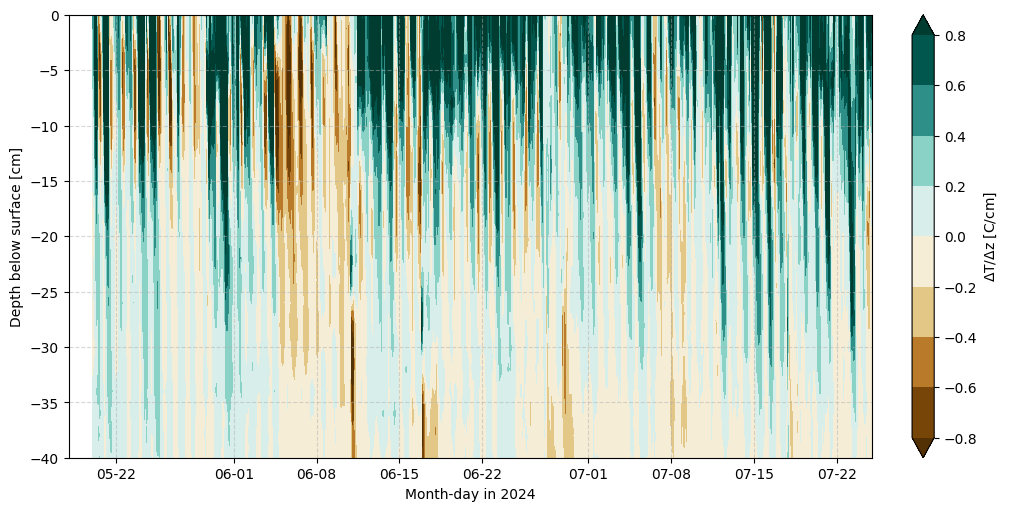

In [290]:
fig, ax = plt.subplots(1, figsize=(10,5), constrained_layout=True)

cb = ax.contourf(season_data_solar['dates'], sub_depths, np.swapaxes(grads_rel_to_sfc,0,1),
                cmap=plt.cm.BrBG, levels=np.arange(-.8,.81,.2), extend='both')
plt.colorbar(cb, label='$\Delta$T/$\Delta$z [C/cm]')

ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
ax.set_ylabel('Depth below surface [cm]')
ax.grid(alpha=.5, ls='--')
# ax.set_ylim(-170,0)
ax.set_ylim(-40,0)
plt.show()

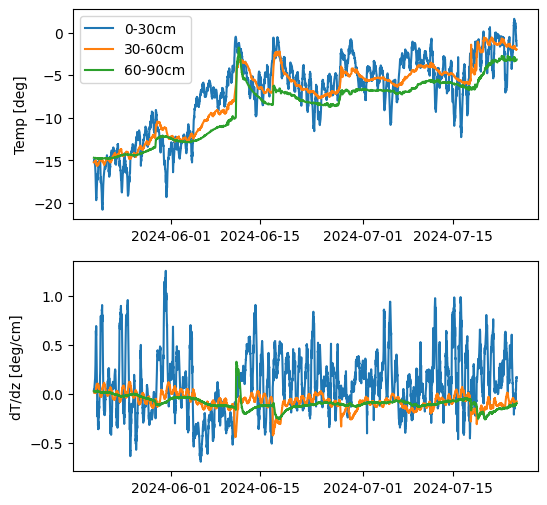

In [265]:
## temperautre in "responsive layer" and further down

temp_upper_30 = temps_rel_to_sfc[:,np.where(sub_depths>=-30)[0]].mean(axis=1)
temp_mid_30_60 = temps_rel_to_sfc[:,np.where((sub_depths<-30)&(sub_depths>=-60))[0]].mean(axis=1)
temp_mid_60_90 = temps_rel_to_sfc[:,np.where((sub_depths<-60)&(sub_depths>=-90))[0]].mean(axis=1)

grad_upper_30 = grads_rel_to_sfc[:,np.where(sub_depths>=-30)[0]].mean(axis=1)
grad_mid_30_60 = grads_rel_to_sfc[:,np.where((sub_depths<-30)&(sub_depths>=-60))[0]].mean(axis=1)
grad_mid_60_90 = grads_rel_to_sfc[:,np.where((sub_depths<-60)&(sub_depths>=-90))[0]].mean(axis=1)

fig, axs = plt.subplots(2, figsize=(6,6))
axs[0].plot(season_data_solar['dates'], temp_upper_30, label='0-30cm')
axs[0].plot(season_data_solar['dates'], temp_mid_30_60, label='30-60cm')
axs[0].plot(season_data_solar['dates'], temp_mid_60_90, label='60-90cm')

axs[0].set_ylabel('Temp [deg]')
axs[0].legend(loc='best')


axs[1].plot(season_data_solar['dates'], grad_upper_30, label='0-30cm')
axs[1].plot(season_data_solar['dates'], grad_mid_30_60, label='30-60cm')
axs[1].plot(season_data_solar['dates'], grad_mid_60_90, label='60-90cm')

axs[1].set_ylabel('dT/dz [deg/cm]')

plt.show()
# season_data_solar['dates'], sub_depths, np.swapaxes(

In [294]:
sleigh_dates = asfs_data_lev2['dates']

In [295]:
## local time is offset by two hours so 12 should be shifted?
big_melt_noon = datetime.datetime(2024,7,16,12)
other_melt_noon = datetime.datetime(2024,6,9,12)

# other_melt_noon = datetime.datetime(2024,6,28,12)
# other_melt_noon = datetime.datetime(2024,7,6,12) ## july 6 might have had three days in a row of melt, but GPR doesn't show continuous melt

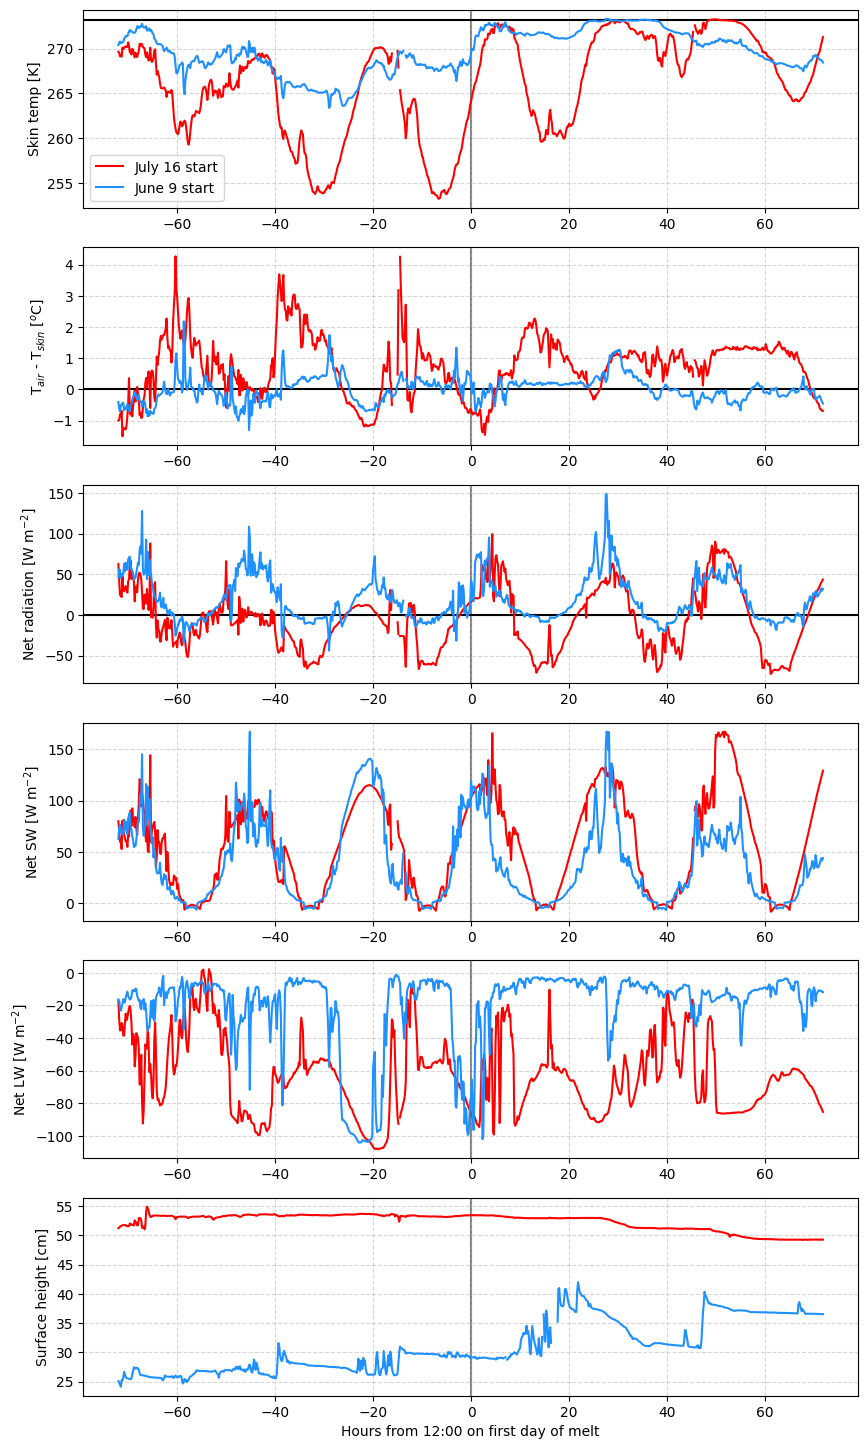

In [296]:
fig, axs = plt.subplots(6, figsize=(10,18))

labels = ['July 16 start','June 9 start']
# labels = ['July 17 start','July 6 start']
# labels = ['July 17 start','June 28 start']

colors = ['r', 'dodgerblue']
axs[0].axhline(y=273.15,c='k')
axs[1].axhline(y=0,c='k')
axs[2].axhline(y=0,c='k')


melt_length = 24*3

sleight_vars = ['skin_temp','T2m_Tskin','net_rad','net_sw','net_lw','snow_depth']

for i, melt_period in enumerate([big_melt_noon, other_melt_noon]):
    melt_period_idx = np.where((sleigh_dates>=melt_period-datetime.timedelta(hours=72))&(sleigh_dates<melt_period+datetime.timedelta(hours=melt_length)))[0]

    hours_since = [(d-melt_period).total_seconds() / 3600. for d in sleight_dates[melt_period_idx]]

    for ax, var in zip(axs.ravel(),sleight_vars):
        ax.plot(hours_since, (asfs_data_lev2[var])[melt_period_idx], label=labels[i],  c=colors[i])

    simba_period_idx = np.where((season_data_solar['dates']>=melt_period-datetime.timedelta(hours=72))&(season_data_solar['dates']<melt_period+datetime.timedelta(hours=melt_length)))[0]
    simba_hours_since = [(d-melt_period).total_seconds() / 3600. for d in season_data_solar['dates'][simba_period_idx]]


ylabels = ['Skin temp [K]','T$_{air}$ - T$_{skin}$ [$^o$C]', 'Net radiation [W m$^{-2}$]',
           'Net SW [W m$^{-2}$]', 'Net LW [W m$^{-2}$]', 'Surface height [cm]']
for ax, yl in zip(axs.ravel(),ylabels):
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel(yl)
    ax.axvline(x=0, c='gray', zorder=0)
axs[0].legend(loc='best')
axs[-1].set_xlabel('Hours from 12:00 on first day of melt')
plt.show()

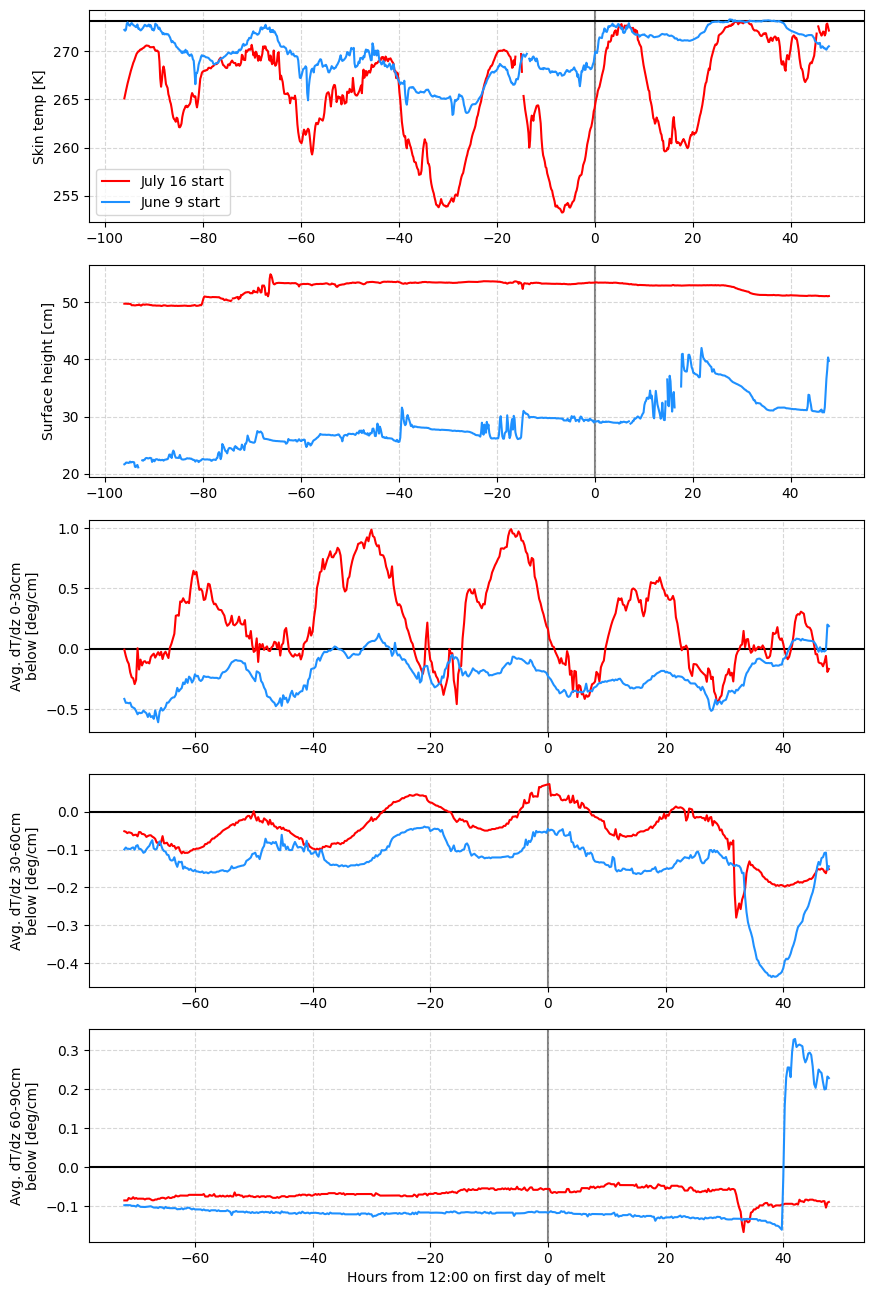

In [297]:
fig, axs = plt.subplots(5, figsize=(10,16))

labels = ['July 16 start','June 9 start']
# labels = ['July 17 start','July 6 start']
# labels = ['July 17 start','June 28 start']

colors = ['r', 'dodgerblue']
axs[0].axhline(y=273.15,c='k')

axs[-3].axhline(y=0,c='k')
axs[-2].axhline(y=0,c='k')
axs[-1].axhline(y=0,c='k')

melt_length = 48

sleight_vars = ['skin_temp','snow_depth']

for i, melt_period in enumerate([big_melt_noon, other_melt_noon]):
    melt_period_idx = np.where((sleigh_dates>=melt_period-datetime.timedelta(hours=24*4))&(sleigh_dates<melt_period+datetime.timedelta(hours=melt_length)))[0]

    hours_since = [(d-melt_period).total_seconds() / 3600. for d in sleight_dates[melt_period_idx]]

    for ax, var in zip(axs.ravel(),sleight_vars):
        ax.plot(hours_since, (asfs_data_lev2[var])[melt_period_idx], label=labels[i],  c=colors[i])

    simba_period_idx = np.where((season_data_solar['dates']>=melt_period-datetime.timedelta(hours=72))&(season_data_solar['dates']<melt_period+datetime.timedelta(hours=melt_length)))[0]
    simba_hours_since = [(d-melt_period).total_seconds() / 3600. for d in season_data_solar['dates'][simba_period_idx]]

    for j, var in enumerate([grad_upper_30, grad_mid_30_60, grad_mid_60_90]):
        axs[len(sleight_vars)+j].plot(simba_hours_since, var[simba_period_idx], label=labels[i],  c=colors[i])

ylabels = ['Skin temp [K]','Surface height [cm]','Avg. dT/dz 0-30cm\nbelow [deg/cm]', 
        'Avg. dT/dz 30-60cm\nbelow [deg/cm]', 'Avg. dT/dz 60-90cm\nbelow [deg/cm]']
for ax, yl in zip(axs.ravel(),ylabels):
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel(yl)
    ax.axvline(x=0, c='gray', zorder=0)
axs[0].legend(loc='best')
axs[-1].set_xlabel('Hours from 12:00 on first day of melt')
plt.show()

Continuous melt below surface because it was clear w/ more SW that transmits??

Would be good to add precip (important for albedo)

temp gradients instead of average temperatures?

## Compare response/variability/correlation of temperatures/gradients and radiation

In [299]:
# need atm to be on same time steps
sleigh_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in sleigh_dates])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in season_data_solar['dates']])

In [316]:
interped_vars = {}

var_names = ['skin_temp','T2m_Tskin','net_rad','net_sw','net_lw','albedo']

for var in var_names:
    var_data = np.ma.masked_invalid(asfs_data_lev2[var])
    f_var = interpolate.interp1d(sleigh_seconds[~var_data.mask], var_data[~var_data.mask], 
                                 fill_value=-999, bounds_error=False)
    
    interp_var = f_var(simba_seconds)
    interped_vars[var] = np.ma.masked_equal(interp_var, -999)



In [320]:
interped_vars['albedo'] = np.ma.masked_greater(interped_vars['albedo'], 1)

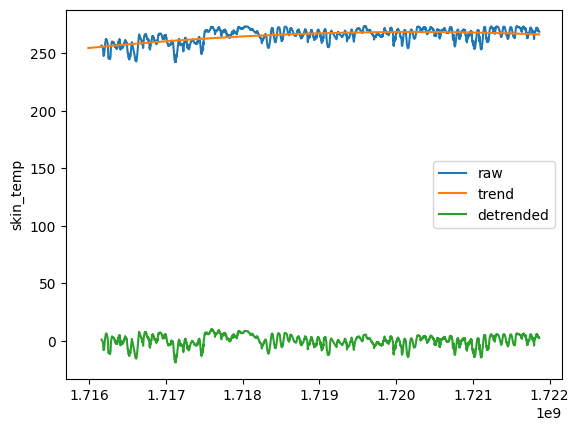

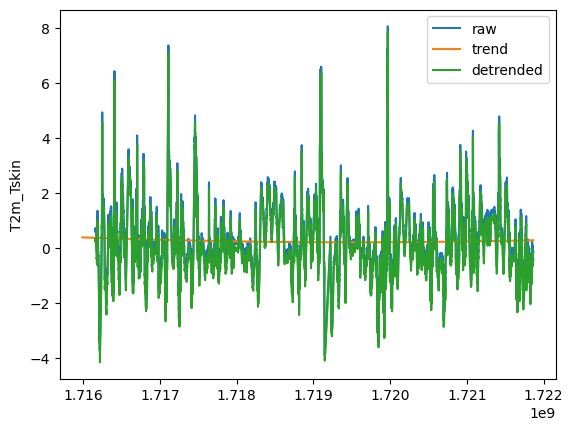

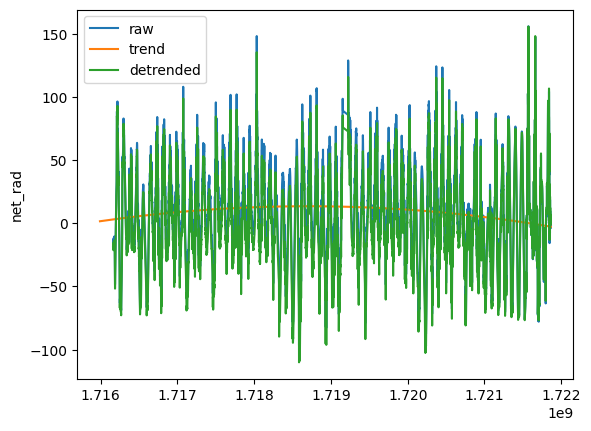

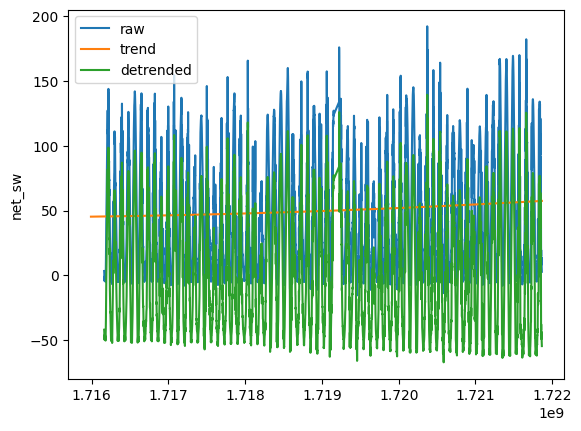

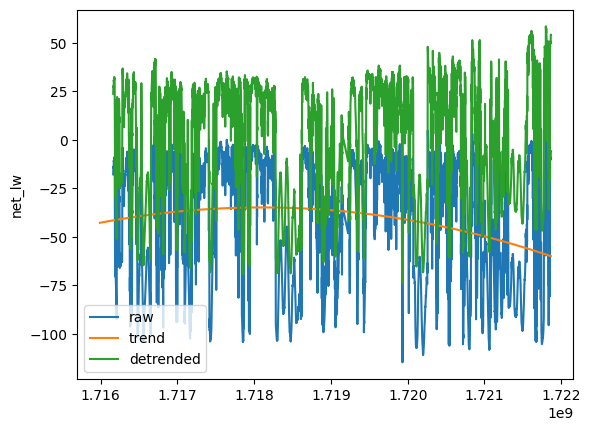

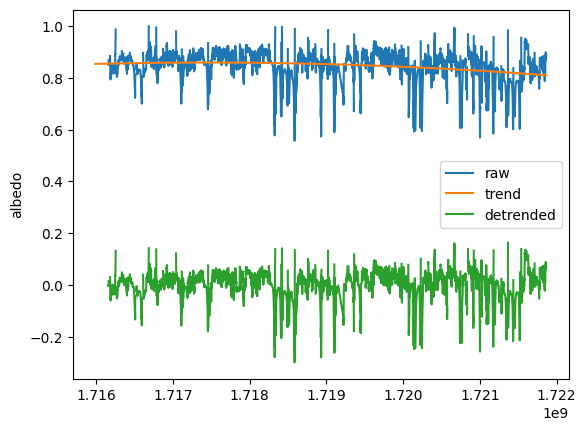

In [324]:
detrended_sleigh_vars = {}

x = simba_seconds

for var in var_names:
    y = interped_vars[var]
    coeff = np.ma.polyfit(x, y, 2)

    # no need to use the original x values here just for visualizing the polynomial
    x_poly = np.linspace(x.min(), x.max())
    y_poly = np.polyval(coeff, x_poly)
    
    # we need the original x values here, so we can remove the trend from all points
    trend = np.polyval(coeff, x)
    t_detrend = y - trend
    # note that simply subtracting the trend might not be enough for other data sets
    # slopes_with_depth.append(coeff[0])

    plt.ylabel(var)
    plt.plot(x, y, label='raw')
    plt.plot(x, trend, label='trend')
    plt.plot(x, t_detrend, label='detrended')
    plt.legend(loc='best')
    plt.show()
    detrended_sleigh_vars[var] = t_detrend

In [322]:
simba_correlations_with_depth = {}

for var in detrended_sleigh_vars:
    detr_data = detrended_sleigh_vars[var]
    
    simba_correlations_with_depth[var] = np.ma.corrcoef(detr_data, detrend_temps[:,:].T)[0][1:]

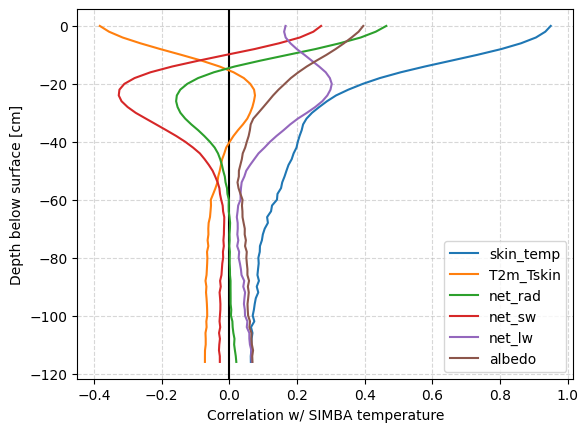

In [323]:
plt.axvline(x=0, c='k')
for var in simba_correlations_with_depth:
    plt.plot(simba_correlations_with_depth[var][~temp_std_full.mask], sub_depths[~temp_std_full.mask], label=var)

plt.ylabel('Depth below surface [cm]')
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
plt.xlabel('Correlation w/ SIMBA temperature')
plt.show()

In [ ]:
plt.plot()